In [1]:
import os

PROJECT_ROOT = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'
DATA_DIR = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'
GRAPHS_DIR = os.path.join(PROJECT_ROOT, 'latex', 'graphs')
GRAPHS_WEB_DIR = os.path.join(PROJECT_ROOT, 'nlp_code', 'latex', 'graphs')

RANDOM_SEED = 101
PROFIT_MARGIN = .15
LIQUIDATION_RECOVERY = .3

In [2]:
import os
import pickle
from datetime import datetime
# import numba as nb
import scipy
import matplotlib.pyplot as plt

from io import StringIO
import sys


import numpy as np
import pandas as pd
from itertools import compress


def get_dt_index(df: pd.DataFrame, dt_index_col=None, is_rename_date: bool = True):
    if dt_index_col is None: dt_index_col = 'date'
    df = df.set_index(pd.DatetimeIndex(df[dt_index_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))))
    if dt_index_col in df.columns:
        df = df.drop(dt_index_col, axis=1)
    if is_rename_date: df.index.name = 'date'
    return df


def load_pd_df(file_name, file_path=None, is_replace_nan=True, **kwargs):
    file_type = file_name.split('.')[-1]

    if file_path is None:
        file_path = DATA_DIR

    if file_type == 'csv':
        return pd.read_csv(os.path.join(file_path, file_name), **kwargs)
    elif file_type == 'xlsx':
        return pd.read_excel(os.path.join(file_path, file_name), **kwargs)
    elif file_type == 'feather':
        df = pd.read_feather(os.path.join(file_path, file_name), **kwargs)
        # if is_replace_nan:
        #     warnings.warn("replacing nan for feather format, pass 'is_replace_nan=False' to disable")
        #     df = df.replace({'nan': np.nan})
        return df
    else:
        raise KeyError(f"{file_type} unknown")


def save_pd_df(df, file_name: str, file_path=None):
    file_type = file_name.split('.')[-1]
    if file_path is None:
        file_path = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'

    if file_type == "csv":
        df.to_csv(os.path.join(file_path, file_name))
    elif file_type == "feather":
        df.to_feather(os.path.join(file_path, file_name))
    else:
        raise KeyError(f"{file_type} unknown")




class Capturing(list):
    def __init__(self, file_name: str):
        self.file_name = file_name
        pass

    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args, **kwargs):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout
        write_to_txt("\n".join(self), self.file_name, file_dir=os.getcwd())


def write_to_txt(output: str, file_name, file_dir=None):
    if file_dir is None: file_dir = GRAPHS_DIR
    f = open(os.path.join(file_dir, file_name), 'w+')
    f.write(output)
    f.close()
    pass


def save_pkl(file: dict, f_name: str, f_path: str = None):
    if f_path is None:
        f_path = "_"
    t = open(os.path.join(f_path, f"{f_name}"), "wb+")
    pickle.dump(file, t)
    t.close()
    pass

def save_fig(fig, f_name: str, f_path: str = None):
    if f_path is None:
        f_path = GRAPHS_DIR
    fig.savefig(os.path.join(f_path, f_name))
    pass


def load_pickle(f_name, f_path=None):
    if f_path is None:
        f_path = "_"
    t = open(os.path.join(f_path, f_name), 'rb')
    file = pickle.load(t)
    t.close()
    return file


def arr_min_max_scale(arr):
    if arr.min() != arr.max():
        return (arr - arr.min()) / (arr.max() - arr.min())
    else:
        return arr


def pd_join_freq(df1, df2, freq: str = 'D', keep_left_index: bool = True, **kwargs):
    df1, df2 = df1.copy(), df2.copy()
    
    for d in [df1, df2]:
        assert d.index.name != freq, "pls change index name"
        
    if keep_left_index:
        df1[df1.index.name] = df1.index
        # df2['index_right'] = df2.index
    
    df1[freq] = df1.index.to_period(freq)
    df2[freq] = df2.index.to_period(freq)
    
    df = pd.merge(df1, df2, on=freq, **kwargs).set_index(freq) #, axis=1)
    df.index = df.index.to_timestamp()
    if keep_left_index:
        df = df.set_index(df1.index.name, drop=False)
    return df


def cross_corr(arr1, arr2, lags: int = 10, is_plot: bool = True, **kwargs):
    assert arr1.shape == arr2.shape, "please ensure both arrays are of same dimensions"
    
    lags = min(len(arr1)-1, lags)
    y1, y2 = 2/np.sqrt(len(arr1)), -2/np.sqrt(len(arr1))
    corr = scipy.signal.correlate(arr2, arr2, mode='full', **kwargs)
    corr = corr[len(arr1)-1-lags: len(arr2)-1+lags]

    idx = np.linspace(-lags,lags, lags*2)
    
    if is_plot:
        fig, ax = plt.subplots(1,1)        
        ax.fill_between(idx, y1, y2, alpha=.2)
        ax.axhline(y=0, color='black')
        ax.bar(idx, corr, color='blue', width=.5)
        ax.set_xlabel(f'no. of lags')
        ax.set_ylabel(f'correlation')
        ax.set_title(f"Cross correlation with {lags} lags")
        plt.tight_layout()
        
        return idx, corr, y1, y2, fig
    
    else:
        return idx, corr, y1, y2

In [3]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', 'lags', 'obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig, axes


def simulate_brownian_motion(N, T, r, sigma, P0, n):
    dt = T / n

    paths = np.zeros((N, n + 1))
    paths[:, 0] = np.log(P0)  # Use the natural logarithm of the initial price

    for i in range(1, n + 1):
        # Generate normal random shocks
        dW = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)

        # Update paths using the volatility-adjusted shocks and natural logarithms
        paths[:, i] = paths[:, i - 1] + dW

    # Exponentiate to get the simulated paths of prices
    paths = np.exp(paths)
    
    return paths

def simulate_return_draws(N_sim, T_sim, P0, rets: np.array):
        
    simulations = np.zeros((N_sim, T_sim))
    
    for i in range(0, N_sim):
        ind = np.random.randint(0, len(rets), T_sim)
        simulations[i] = rets[ind]
    
    # cumulated product departing from p0
    simulations = simulations + 1
    simulations[:, 0] = simulations[:, 0] * P0
    simulations = np.cumprod(simulations, axis=1)

    return simulations

def get_lookback_price(sims, T, N, r_e, P0):
    sim_max = sims.max(axis=1)
    G0 = np.exp(-r_e * T) * 1 / N * np.sum(sim_max) - P0
    sigma_y = 1 / N * np.sum((sim_max - np.mean(sim_max)) ** 2)
    print(G0, sigma_y)
    
    # mu = np.linspace(P0, P0 + G0, T_sim)
    
    # upper = np.linspace(P0, P0 + G0 + G0 * 1.96 * sigma_y, T) 
    # lower = np.linspace(P0, P0 + G0 - G0 * 1.96 * sigma_y, T) 
    u, l = G0 + 1.96 * sigma_y, G0 - 1.96 * sigma_y

    return sim_max, G0, mu, u, l, sigma_y

def write_to_txt(output: str, file_path):
    f = open(file_path, 'w+')
    f.write(output)
    f.close()
    pass

In [4]:
import pymc as pm
from pymc_experimental.statespace.core.statespace import PyMCStateSpace

from pymc_experimental.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
)
from pymc_experimental.statespace.models.utilities import make_default_coords

import pytensor.tensor as pt
import jax
import numpyro

jax.config.update("jax_platform_name", "cpu")
numpyro.set_host_device_count(4)

In [5]:
import pandas as pd
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os
import scipy

In [6]:
import eurostat

In [7]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [8]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [9]:
plt.rcParams["figure.figsize"] = (12,3)

# Question 1
"Expand the data base for proxies of your policy target inflation and your policy target for the longest period. Provide the link to the database (FRED, ECB, BdF, BoE, IMF, WB and so on) related to your time series. For example, do no use the CPI index but its growth rate (or difference of log) which measure inflation."

## load data

In [10]:
codes = eurostat.get_toc_df()
[i for i in codes['title'] if 'interest'.lower() in i.lower()];
codes[codes['title'] == 'Interest rates - monthly data'];

#### The Harmonised Index of Consumer Prices (EUROSTAT, 2024)
This monthly series gives comparable measures of inflation calculated from the set of Consumer Price Indicies. It is an indicator of inflation that measures the change over time of consumer goods and services. Importantly, the HICP is the official measure of consumer price inflation in the euro area for the purposes of monetary policy and hence is the most suitable measure for the policy rule. 

In [11]:
# cpi
data = eurostat.get_data('PRC_HICP_MIDX', filter_pars={'geo': ['EA20']})
df = pd.DataFrame(data[1:], columns=data[0])
cpi = df[(df['freq'] == 'M') & (df['unit'] == 'I05') & (df['geo\\TIME_PERIOD'] == 'EA20') & (df['coicop'] == 'CP00')].T.dropna().iloc[4:]
cpi.columns = ['cpi']
cpi.index = [datetime.strptime(x, "%Y-%m") for x in cpi.index]

save_pd_df(cpi.reset_index(names=['date']), 'cpi.feather')

#### Private Sector Credit Flow (EUROSTAT, 2024)
The private sector credit flow represents the net amount of liabilities (debt securities and loans) in which the sectors Non-financial corporations and households and non-profit serving households have incurred throughout the year. 

The TIPSPC20 is presented both as percent of GDP and in millions of units of national currency (MIO_NAC), which is utilised here. The institutional sectors taken into account are non-financial corporations (principal activity is production of goods and non-financial services), households and non-profit institutions serving households (principal resources are voluntary contributions in cash or in kind).

This annual series is key for policy makers to monitor the growth of credit in an economy, assess financial stability and contextualise decisions surrounding monetary policy, like the setting of interest rates.

In [12]:
# private sector credit
filt = 'TIPSPC20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
pc_gdp = df[(df['geo\\TIME_PERIOD'] == 'EA20') & (df['unit'] == "MIO_NAC")].T.iloc[7:]
pc_gdp.columns = ['pc_gdp']
pc_gdp.index = [datetime(int(str(x)),1,1) for x in pc_gdp.index]

save_pd_df(pc_gdp.reset_index(names=['date']), 'pc_gdp.feather')

#### General Government Gross Debt (EUROSTAT, 2024)
Government debt is the total consolidated gross debt at nominal (face) value outstanding at the end of the year and consolidated between, and within the sectors of general government. The data is in millions of national currency (MIO_NAC).

The government debt has implications for fiscal policy. High levels of debt to GDP imply difficulty in meeting budgetary requirements and may precede lower levels of consumer confidence.

In [13]:
# public debt to gdp
filt = 'TIPSGO20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
pd_gdp = df[(df['unit'] == "MIO_NAC")].T.iloc[7:].dropna().sum(axis=1).rename('pd_gdp')
pd_gdp = pd.DataFrame(pd_gdp)
pd_gdp.index = [datetime(int(x[:4]), int(x[-1])*3-2, 1) for x in pd_gdp.index]

save_pd_df(pd_gdp.reset_index(names=['date']), 'pd_gdp.feather')

#### Gross Domestic Product (GDP) at Market Prices (EUROSTAT, 2024)
This is a quarterly time series measured in current prices in millions of units of national currency. GDP is a measure of production activity of resident producers and defines the value of all goods and services produced in the Euro area. This data is seasonally adjusted.

In [14]:
# gdp
filt = 'TIPSAU20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
gdp = df[(df['s_adj'] == "NSA")]
gdp = gdp.iloc[:, 5:].rename(columns={'geo\TIME_PERIOD': 'country'})
gdp = pd.DataFrame(gdp.sum(), columns=['gdp'])
gdp.index = [datetime(int(x[:4]), int(x[-1])*3-2, 1) for x in gdp.index]

save_pd_df(gdp.reset_index(names=['date']), 'gdp.feather')

#### Interest Rates (EUROSTAT, 2024)
This is a seasonally unadjusted monthly time series of 3-month averaged interest rates. The indicator extracted is the short-term interest rates. This is the day-to-day money market interest rates. It is an average for the euro area (Euro OverNight Index Average) and then averaged over 3-months. 

In [15]:
# interest rates
filt = 'EI_MFIR_M'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
ir = df[(df['geo\\TIME_PERIOD'] != "EA28") & (df['geo\\TIME_PERIOD'] != "EU27_2020") & (df['indic'] == "MF-3MI-RT")]
ir = pd.DataFrame(ir.iloc[:, 5:].median(axis=0), columns=['ir'])
ir.index = [datetime(int(x[:4]), int(x[-2:]), 1) for x in ir.index]
ir /= 100

save_pd_df(ir.reset_index(names=['date']), 'ir.feather')

## Summary of Datasets
The description of the data is presented here. However, the data can be downloaded, and transformations performed, directly with this notebook using the eurostat package. In other words, the results are replicable with this notebook alone.

| Eurostat Code | Link | Description | Frequency | Transformation |
| --- | --- | --- | --- | --- |
| PRC_HICP_MIDX | https://ec.europa.eu/eurostat/databrowser/view/PRC_HICP_MIDX__custom_1439028/default/table?lang=en | Harmonised index of consumer prices (HICP) (prc_hicp)| Monthly | Logged and first differenced for monthly inflation rate. Later compounded for annualised inflation. | 
| TIPSPC20 | https://ec.europa.eu/eurostat/databrowser/view/tipspc20/default/table | Private sector credit flow (tipspc) | Annual || 
| TIPSGO20 | https://ec.europa.eu/eurostat/databrowser/view/tipsgo20/default/table?lang=en | General government gross debt (EDP concept), consolidated - quarterly data | Quarterly | | 
| TIPSAU20 | https://ec.europa.eu/eurostat/databrowser/view/tipsau20/default/table?lang=en&page=SCA | Gross domestic product (GDP) at market prices - quarterly data | Quarterly |  | 
| EI_MFIR_M | https://ec.europa.eu/eurostat/databrowser/view/EI_MFIR_M__custom_5797138/default/table?lang=en | Monetary and financial indicators (ei_mf). Interest rates monthly data. This dataset provides interest rates that are not seasonally adjusted for   | Monthly | | 

Reference: EUROSTAT, 2024

## Merge

In [16]:
df = pd.DataFrame(index=pd.date_range(start=datetime(1999,1,1), end=datetime.today()))
for d in ['cpi', 'ir', 'gdp', 'pd_gdp', 'pc_gdp']:
    df = df.join(load_pd_df(f'{d}.feather').set_index('date'))
df = df.dropna(thresh=1)

## Transformations
Here, we take the difference in the logged Consumer Price Index to calculate the monthly inflation rate.

For GDP, the Hodrick-Prescott (HP) filter is applied to separate the series into the cyclical component and trend (Hodrick and Prescott, 1997). The trend component contains a deterministic of stochastic trend and is supposed to be more sensitive to long-term fluctuations than short-term. The filter is the solution to the following problem:
$$
y_{t} = \tau_{t} + c_{t}
$$ $$
min_{\{\tau_{t}\}} \{ \Sigma^{T}_{t=1} (y_{t} - \tau_{t})^2 + \lambda \Sigma^{T-1}_{t=2} [(\tau_{t+1} - \tau_{t}) - (\tau_{t} - \tau_{t-1})]^{2} \}
$$

where $y_t$ is the original series, $\tau_{t}$ is the trend component and $c_{t}$ is the cyclical component. The HP filter minimises the deviation of the original series from the trend as well as the curvature of the estimated trend (OECD, 2019). The cyclical component is renamed gdp_cyc and the trend component renamed gdp_trend.

In [17]:
#Note for Lukas: df = df.join(trend.rename('gdp_trend')) was originally df = df.join(cyc.rename('gdp_trend')). There was a mistake in the code.

In [18]:
df['pi_M'] = np.log(df.cpi).diff()

cyc, trend = hpfilter(np.log(df.gdp.dropna()))
df = df.join(cyc.rename('gdp_cyc'))
df = df.join(trend.rename('gdp_trend'))
df['ir_diff'] = df.ir.diff()

df['M'] = df.index.month

In [19]:
## astype

In [20]:
dict_parse = {'cpi': float,
 'ir': float,
 'gdp': float,
 'pd_gdp': float,
 'pc_gdp': float,
 'pi_M': float,
'pi_M': float,
 'gdp_cyc': float,
 'gdp_trend': float,
 'M': 'category'}

In [21]:
df = df.astype(dict_parse)
df = df.asfreq('MS')

# Question 2
"Check if there is seasonal adjustment or not: you may regress your time series on seasonal dummies. CHECK if the scale of the time series is comparable: for example, monthly Inflation is not multiplied by 12 to have an "annual" scale for this monthly data, whereas the monthly Fed funds rate is multiplied by 12. You will have incredible REAL interest rates. COMMENT. Then adjust for the same scale, because in regressions, the ratio of standard errors of each variables will be multiplied or divided by 12 because of these difference of scale."

pi_M is a variable created from the monthly CPI index PRC_HICP_MIDX. It is the first difference of the logged CPI giving us the monthly inflation rate. In calculating inflation in this way, we have avoided the annualisation of monthly inflation rates. The figure commonly presented by central banks is the yearly inflation for a given month. They say "inflation this month is 4%". This does not mean that prices are going to rise by 4% this month, it means that as of this month, prices are expected to rise by 4% over the year given the monthly change in CPI. As it stands, estimating the policy rule from the monthly inflation data but with an annualised interest rate would give us an extreme policy rule. The 'F' parameter that we saw in class would be extremely large because we would be using interest rates over one year as a response to inflation over one month.

The inflation rate must be adjusted so that it coincides with the interest rate being annualsied. To do this, the inflation rate is compounded over the previous 12 months. We lose the first 12 months of observations, and the first pi_Y observation we have for 2000-12-01 is the product of 1+pi_M for the 12 previous months. We now have a match between the annualised interest rate and annualised inflation rate.

Following this, we check for seasonality. Seasonal adjustment to data attempts to remove predictable seasonal patterns from data. Seasonal adjustments make it easier to observe the cyclical, underlying trend, and other nonseasonal movements in the series.(Bureau of Labor Statistics, 2022).

There is clear cyclicality in the series. For the monthly inflation, all the monthly dummy coefficients are significant at least to the 90% confidence level. Only one has a p-value above 0.01. The residuals of the OLS regression are saved as pi_M_resid, the non-cylical monthly (non-annualised) inflation rate. Note that no constant is included in these regressions to avoid the dummy variable trap. The dummy variable trap occurs if there are N categories and each observation falls in one of the N categories but no more. If we use all N dummy variables as regressors and include a constant, then the regressors will fail because of perfect multicollinearity. To avoid this, use N dummies and no constant, or N-1 dummies and a constant (Stock & Watson, 2020).

The same can be said for GDP_cyc. There is some degree of seasonality detected by an OLS with quarterly dummies after the HP filter's application, but only half of the coefficients are significant. For the GDP_trend, which should be the long-run trend of GDP and be unchanged by quarterly variations, all coefficients are significant suggesting the HP filter has been unsuccessful in extracting the seasonality component. The residuals from both regressions are extracted for cyclical and trend GDP with seasonality removed.

In [22]:
for col in ['pi_M', 'gdp_cyc', 'gdp_trend']:
    sub = df[[col, 'M']].dropna().copy()
    sub['M'] = sub.M.astype(int).astype('category')
    sub = sub.drop('M', axis=1).join(pd.get_dummies(sub['M'], prefix='m').iloc[:, :-1])
    x = sub.drop(col, axis=1)
    X = sm.add_constant(x).astype(int)
    ols = OLS(sub[col], X).fit()

    
    df = df.join(ols.resid.rename(f'{col}_resid'))
    print(col, '\n', ols.summary())

pi_M 
                             OLS Regression Results                            
Dep. Variable:                   pi_M   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     41.69
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.66e-52
Time:                        18:36:31   Log-Likelihood:                 1288.7
No. Observations:                 290   AIC:                            -2553.
Df Residuals:                     278   BIC:                            -2509.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.574  

It is in the cell below that the annualised monthly inflation rate is calculated by compounding the monthly inflation rate. The compound annual growth rate formula is:
$$
\pi_Y = (\Pi^{12}_{i=1} (1+\pi_{M_i})) -1
$$
where a rolling product is used over the last 12 months. In this way, the inflation rate for the december is reflective of the overall inflation rate since January. The value of $\pi_Y$ for January is the product of all of the monthly inflation rates since February of the previous year et cetera.

In [23]:
df['pi_Y'] = (1+df.pi_M).rolling(12).apply(np.prod, raw=True) - 1
#df['pi_Y'] = df.pi_M * 12
#df['pi_Y_resid'] = (1+df.pi_M_resid).rolling(12).apply(np.prod, raw=True) - 1

for col in ['pi_Y']:
    sub = df[[col, 'M']].dropna().copy()
    sub['M'] = sub.M.astype(int).astype('category')
    sub = sub.drop('M', axis=1).join(pd.get_dummies(sub['M'], prefix='m').iloc[:, :-1])
    x = sub.drop(col, axis=1)
    X = sm.add_constant(x).astype(int)
    ols = OLS(sub[col], X).fit()

    
    df = df.join(ols.resid.rename(f'{col}_resid'))
    print(col, '\n', ols.summary())
   

pi_Y 
                             OLS Regression Results                            
Dep. Variable:                   pi_Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                  0.001623
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               1.00
Time:                        18:36:32   Log-Likelihood:                 712.21
No. Observations:                 279   AIC:                            -1400.
Df Residuals:                     267   BIC:                            -1357.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0213      0.004      5.423  

Hence, the data we use forewards is as follows:

| Data | Indicator| Range |
|---|---|---|
|Inflation Annualised (compounded)|pi_Y|2000-01-01 to 2024-02-01 |
|inflation annualised (compounded)residuals from seasonality regression (deseasonalised)| pi_Y_resid| 2000-12-01 to 2024-02-01|
|interest rate annualised| ir | 1999-01-01 to 2024-02-01|

# Question 3

"Copy a plot of the two time series over time."

### Inflation and Interest Rates

Recall that pi_Y is the compounded monthly inflation rate, using the previous 12 months' inflation rate as the inputs and pi_Y_resid is the residual from the seasonality regression. Not much changes between pi_Y and pi_Y_resid. The explanatory power of the monthly dummies was so weak, and the $R^2$ was so low that the time series' movements are almost identical, all that changes is there is a translation along the y-axis. This is because the intercept, which is essentially the average inflation rate (which we could say is the 'target' inflation), is subtracted from the series when we take the residual. This means that our pi_y_resid series is just pi_Y $- 0.0213$. This is like taking 2% off the inflation rate which the ECB has as its inflation target.

In the figure, we see stability in pi_Y at around 2% until the Global Financial Crisis in 2008. In 2008, the inflation rate rises initially, then cascades in mid-2008 towards the negatives in mid-2009. We can see from the descriptive statistics that the minimum inflation rate for pi_Y is -0.6%. The 'deviation from target' is -2.5%. Interest rates follow in a similar fashion, displaying what appears to be less variation than inflation, but tracking the trend of inflation to a large extent, falling to below 2% in 2009 and stauing there until the COVID-19 crisis and the extreme inflation beginning in 2021.

Pre-2021, the interest rate (ir) is highly responsive to the inflation rate, displaying almost no delay and following the inflation rate in tandem. However, the rate was far more stubborn and flat following the GFC, and was much slower to respond after the surge in inflation following the COVID-19 crisis. Rates were historically low following the GFC to stimulate growth and to offset the contractionary fiscal policies necessitated by the costs of the financial crisis. Inflation rates remained at or below target, so the interest rates stayed just in the positive.

Many banks were slow to respond to the inflationary surge following COVID-19 and the invasion of Ukraine because they wanted to ensure downside risks had declined (CEPR, 2024). The delays were to avoid acting too prematurely and exposing economies with already weakened monetary policy transmission mechanisms to financial market volatility, shocks and policy uncertainty. Confidence in the stability of inflation expectations and reluctance to change their guidance on the likely timing of rate increases and duration of asset purchases led to a more delayed but drawn-out response (CEPR, 2024).

<Axes: >

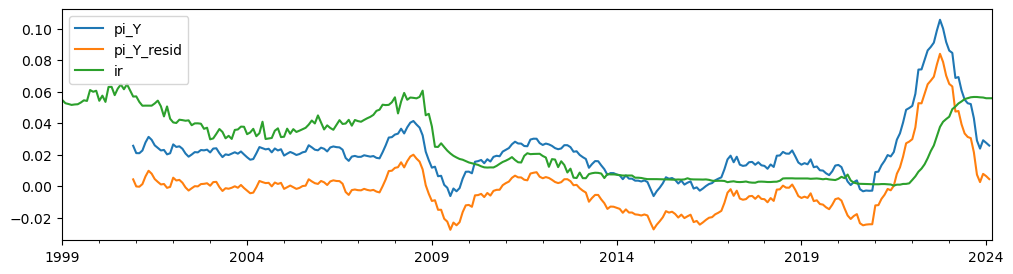

In [24]:
df[['pi_Y', 'pi_Y_resid', 'ir']].plot()

### GDP

Below you can observe the time series of the trend and cyclical components of GDP. Using the HP filter, quarterly GDP was separated into the cyclical and trend components. Naturally the cyclical component shows cyclicality. The cycles appear to be yearly, 

The trend however is a much smoother curve that levels our a little after the global financial crisis but is convex following that. 

<Axes: >

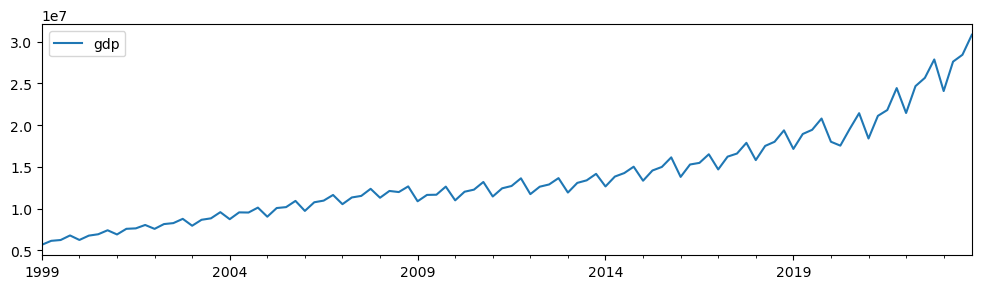

In [25]:
df[['gdp']].dropna().plot()

<Axes: >

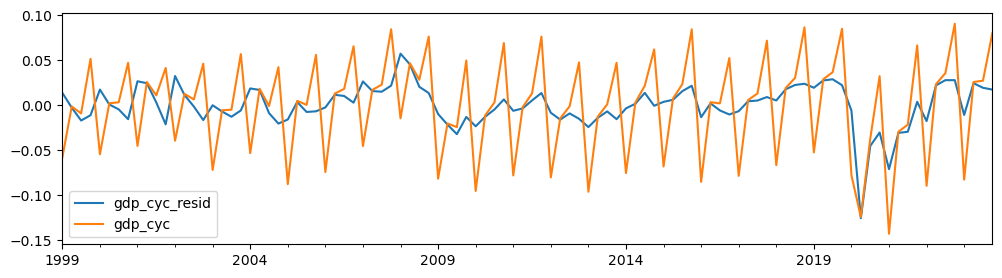

In [26]:
df[['gdp_cyc_resid', 'gdp_cyc']].dropna().plot()

<Axes: >

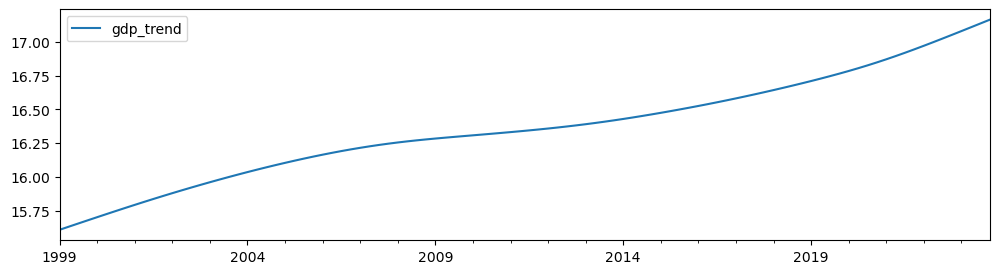

In [27]:
df[['gdp_trend']].dropna().plot()

# Question 4

"Report in a table univariate summary statistics: min max mean median standard errors of policy target and policy instrument."

In [28]:
df[['pi_Y_resid', 'pi_Y', 'ir']].dropna().describe()

,pi_Y_resid,pi_Y,ir
count,2.790000e+02,279.000000,279.000000
mean,9.973106e-18,0.021418,0.022745
std,1.887598e-02,0.018877,0.018911
min,-2.766090e-02,-0.006284,0.000380
25%,-1.003936e-02,0.011373,0.004700
50%,-1.694397e-03,0.019786,0.016902
75%,3.310514e-03,0.024804,0.039695
max,8.398968e-02,0.105601,0.060617


In [29]:
negative_pi_Y_dates = df[df['pi_Y'] < 0].index
print(negative_pi_Y_dates)

DatetimeIndex(['2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01',
               '2009-10-01', '2014-12-01', '2015-01-01', '2015-02-01',
               '2015-03-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)


Dropping the observations for which inflation is missing, we are left with 279 monthly observations for interest rates, annualised inflation and annualised residual inflation. As mentioned above, the mean for pi_Y should be about 2% higher than the mean for pi_Y_resid because of the intercept term being almost an average of the inflation rate across the time series. This is observed here in this table.

The mean interest rate slightly exceeds the mean inflation rate despite the slow response following COVID. This is observed in the plot above with the interest rate line being above the inflation rate lines until the end of the sample. Median inflation and interest rates are around 2% and 1.7% respectively.

Throughout our sample, interest rates never exceed the zero lower bound. The lowest interest rate is 0.038%, practically zero. Inflation on the other hand does fall below zero. pi_Y reaches the negative both in 2009 and also in late 2014, 2015 and 2016. During this period there was simultaneously low inflation and low interest rates. Inflation is also negative during the COVID lockdowns from mid to late 2020.

# Question 5

"Estimate on the full period an AR(1) process and estimate the auto-correlation of its residual (let's denote it: AR(1)-AR(1))"

The series are first examined for presensce of a unit root. We do not expect a unit root given the graphs of the time series above and the Augmented Dickey Fuller tests confirm this. In no case are we able to reject the null that there is presence of a unit root.

In [30]:
lst_q5_cols = ['pi_Y', 'pi_Y_resid', 'ir']

In [31]:
for col in lst_q5_cols:
    adf_test_summary(df[col].dropna())

-----------------------------------------------------------------------------
ADF Test PI_Y: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.842    0.360  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.954    0.626  12.0  266.0 -3.993 -3.427 -3.137
constant ltend, qtrend    -2.900    0.345  12.0  266.0 -4.415 -3.855 -3.567
none                      -0.686    0.418  12.0  266.0 -2.574 -1.942 -1.616


-----------------------------------------------------------------------------
ADF Test PI_Y_RESID: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.827    0.367  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.941    0.633  12.0  266.0 -3.993 -3.427 -

The models estimated are:
$$
\pi_{t+1} = \lambda_{\pi}\pi_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho_{\pi}u_t +\epsilon_{t+1} $$
and for the 'residual' inflation
$$
\pi^{resid}_{t+1} = \lambda^{resid}_{\pi}\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho^{resid}_{\pi}u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = \lambda_{i}i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho_{i}u_t +\epsilon_{t+1} $$

In [32]:

lst_mod_resid, lst_rho_lambda = [], []

#for col in lst_q5_cols:    
#    ar_var = ARIMA(df[col], order=(1,0,0), trend = 'n').fit()
#    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()

#    lst_mod_resid.append(ar_res)
#    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

#summary_col(lst_mod_resid, model_names=lst_q5_cols, stars=True)

In [33]:
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(1,0,0), trend = 'n').fit()
    print(f"Model = {col}")
    print(f"Summary for ARIMA model of {col}:")
    print(ar_var.summary())
    print("\n\n") 
    
    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of residuals of {col}:")
    print(ar_res.summary())
    print("\n\n")
    print("--"*50)
    print("--"*50)

    lst_mod_resid.append(ar_res)
    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

Model = pi_Y
Summary for ARIMA model of pi_Y:
                               SARIMAX Results                                
Dep. Variable:                   pi_Y   No. Observations:                  303
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1184.818
Date:                Tue, 16 Apr 2024   AIC                          -2365.636
Time:                        18:36:46   BIC                          -2358.208
Sample:                    01-01-1999   HQIC                         -2362.664
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9927      0.004    227.779      0.000       0.984       1.001
sigma2      1.181e-05   5.98e-07     19.739      0.000    1.06e-05     1.3e-05
Ljung-

The model results are:
|Autocorrelation parameter| Value| Autocorrelation of residual| value| 
|---|---|---|---|
|$\lambda_{\pi}$| $0.9927^{***}$|$\rho_{\pi}$|$0.2300^{***}$|
|$\lambda^{resid}_{\pi}$|$0.9834^{***}$|$\rho^{resid}_{\pi}$| $0.3063^{***}$|
|$\lambda_{i}$|$0.9964^{***}$| $\rho_{i}$| $-0.0711$|

So
$$
\pi_{t+1} = 0.9927\pi_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.2300u_t +\epsilon_{t+1} $$
and for the 'residual' inflation
$$
\pi^{resid}_{t+1} = 0.9834\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.3063u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = 0.9964i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = -0.0711u_t +\epsilon_{t+1} $$

It would be unusual to observe negative autocorrelation of inflation. Although we haven't controlled for the contractionary/opposite effects of the interest rate on inflation, there remains some positive autocorrelation of inflation almost at 1. The same can be said for interest rates which are also autocorrelated with the coefficient 0.9964.

# Question 6

"Estimate the AR(2) model. Check your estimates are close to the following combination of parameters of the AR(1)-AR(1)"

In [34]:
#lst_mod_ar2 = []
#for col in lst_q5_cols:    
 #   ar_var = ARIMA(df[col], order=(2,0,0)).fit()
 #   lst_mod_ar2.append(ar_var)

In [35]:
#df_summary = summary_col(lst_mod_ar2, model_names=lst_q5_cols, stars=True, )
#df_summary.add_df(pd.DataFrame([(i[0] + i[1], i[0] * i[1]) for i in lst_rho_lambda], index=lst_q5_cols, columns=['rho+lamb', 'rho*lamb']).T)
#df_summary

The models estimated are:
$$
\pi_{t+1} = (\lambda_{\pi}+\rho_{\pi})\pi_{t} - \lambda_{\pi}\rho_{\pi}\pi_{t-1} + u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$ $$
\pi^{resid}_{t+1} = (\lambda^{resid}_{\pi}+\rho^{resid}_{\pi})\pi^{resid}_{t} - \lambda^{resid}_{\pi}\rho^{resid}_{\pi}\pi^{resid}_{t-1} + u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$ and $$
i_{t+1} = (\lambda_i\rho_i)i_t - \lambda_i\rho_ii_{t-1}+u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_iu_t+\epsilon_{t+1}
$$


In [36]:
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(2,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of {col}:")
    print(ar_var.summary())
    print("\n")
    
    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of residuals of {col}:")
    print(ar_res.summary())
    print("\n") 

    lst_mod_resid.append(ar_res)
    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

Summary for ARIMA model of pi_Y:
                               SARIMAX Results                                
Dep. Variable:                   pi_Y   No. Observations:                  303
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1199.153
Date:                Tue, 16 Apr 2024   AIC                          -2392.307
Time:                        18:36:50   BIC                          -2381.166
Sample:                    01-01-1999   HQIC                         -2387.850
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3037      0.046     28.080      0.000       1.213       1.395
ar.L2         -0.3129      0.047     -6.665      0.000      -0.405      -0.221
sigma2      1.063e-

#### Model:
$$
\pi_{t+1} = (\lambda_{\pi}+\rho_{\pi})\pi_{t} - \lambda_{\pi}\rho_{\pi}\pi_{t-1} + u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$

|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda_{\pi} + \rho_{\pi}$| $1.3037^{***}$|
|$- \lambda_{\pi}\rho_{\pi}$|$-0.3129^{***}$|
|$\mu_{\pi}$|$-0.0753$|

We have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda_{\pi} + \rho_{\pi}$|$0.9927 + 0.2300$|$1.2227$|$1.3037$|Very close to AR(1) model: consistent|
|$- \lambda_{\pi}\rho_{\pi}$|$-0.9927 * 0.2300$|$-0.228321$|$-0.3129$|Fairly close to AR(1) model's result|

#### Model:
$$
\pi^{resid}_{t+1} = (\lambda^{resid}_{\pi}+\rho^{resid}_{\pi})\pi^{resid}_{t} - \lambda^{resid}_{\pi}\rho^{resid}_{\pi}\pi^{resid}_{t-1} + u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$

|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda^{resid}_{\pi} + \rho^{resid}_{\pi}$| $1.2973^{***}$|
|$- \lambda^{resid}_{\pi}\rho^{resid}_{\pi}$|$-0.3191^{***}$|
|$\mu_{\pi}$|$-0.0640$|

From our AR(1)-AR(1) and AR(2)-AR(1) models we have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda^{resid}_{\pi} + \rho^{resid}_{\pi}$|$0.9834 + 0.3063$|$1.2897$|$1.2973$|Very close to AR(1) model: consistent|
|$- \lambda^{resid}_{\pi}\rho^{resid}_{\pi}$|$-0.9834 * 0.3063$|$-0.30121542$|$-0.3191$|Also very close|

### Model:
$$
i_{t+1} = (\lambda_i\rho_i)i_t - \lambda_i\rho_ii_{t-1}+u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_iu_t+\epsilon_{t+1}
$$


|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda_{i} + \rho_{i}$| $0.8773^{***}$|
|$- \lambda_{i}\rho_{i}$|$-0.1199^{***}$|
|$\mu_{i}$|$-0.0182$|

We have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda_{i} + \rho_{i}$|$0.9964 + -0.0711$|$0.9253$|$0.8873$|Fairly consistent with AR(1) model|
|$- \lambda_{i}\rho_{i}$|$-0.9964 * -0.0711$|$0.07084404$|$-0.1199$|This is inconsistent. This is because the AR(1) coefficient of the residuals is negative. It is statistically insignificant however, so these results do not necessarily imply a failure of the model.|

Overall, our estimates are close, particularly so for inflation. The only thing throwing the estimates off is the negative autocorrelation of the residuals in the AR(1)-AR(1) model for interest rates. The coefficient is low, but negative. The negative sign means we get an inconsistency when multiplying the $- \lambda_{i}\rho_{i}$. This leaves us with a positive product from the AR(1) model, but a negative value from the AR(2)-AR(1) models. It is worth noting that the p-value for this coefficient was 0.331 so it is statistically insignificant which implies this result is not as damning as at first glance.

# Question 7

"For an AR(p), p ≥ 2, for measuring persistence, should you consider the first auto- regressive parameter only or the sum of the auto-regressive parameters? A PhD student comes to you and states: look the auto-regressive parameter (the first one of the AR(1)) is 1.4, it is above a unit root. What do you answer to him?"

For an AR(P) process where p≥2, it would be incorrect to make this assumption based on the first autoregressive coefficient coefficient alone. The process is autoregressive to an order greater than just 1. We saw with the AR(2) models that the coefficient on the second lag is significant also so it would be a mistake to claim the process is explosive because of the coefficient of 1.4. We must consider the overall combined effects of the lags up to order P to determine whether there is a unit root or not. Indeed, for inflation the coefficient of the first lag is 1.3037 which is above 1 and hence indicates an explosive process. However, the coefficient for the second lag is 0.3129, and considering the sum of the autoregressive parameters gives 0.9908 which is less than 1. If 1.3037 was the only parameter is might suggest an explosive process but it is not the only coefficient: we must consider the sum of the autoregressive parameters.

The individual coefficients of an AR(p) process canot imply a unit root. Instead one needs to consider the combination of coefficients. More specifically, the eigenvalues of the coefficient matrix. Let $\mathbf{\Gamma}$ be the coefficient matrix of an AR(2) process, such that:
$ [a, b] $


In [37]:
lst_mod_ar2 = []
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(2,0,0), trend = 'n').fit()
    lst_mod_ar2.append(ar_var)

In [38]:
phi1 = np.linspace(-2, 2, 100)
phi2 = np.linspace(-2, 2, 100)

stab1 = phi1 + 1
stab2 = 1 - phi1
stab3 = list([-1] * 100)
stab4 = -phi1 ** 2 / 4


Note that there is overlay of the coefs pi_Y_resid and coefs pi_Y on this figure


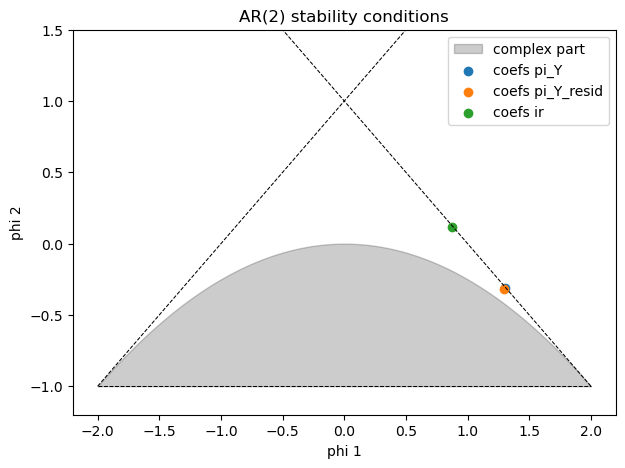

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(phi1, stab1, color='black', linestyle='dashed', lw=.75)
ax.plot(phi1, stab2, color='black', linestyle='dashed', lw=.75)
ax.plot(phi1, stab3, color='black', linestyle='dashed', lw=.75)
# ax.fill_betweenx(stab4, stab1, phi1)
ax.fill_between(phi1, stab3, stab4, color='black', alpha=.2, linestyle='-', label='complex part')

for i, mod in enumerate(lst_mod_ar2):
    ax.scatter(*mod.params.values[:-1], label=f"coefs {lst_q5_cols[i]}")
    ax.set_ylim(bottom=-1.2, top=1.5)

ax.set_title("AR(2) stability conditions")
ax.set_xlabel("phi 1")
ax.set_ylabel("phi 2")

ax.legend()
print('\nNote that there is overlay of the coefs pi_Y_resid and coefs pi_Y on this figure')

Outside of the dashed triangle, the $|\phi_1 + \phi_2| > 1$ the system is explosive. The AR(2) processes satisfy the stability conditions and prove that the PhD student's comments are misguided. We can also confirm that the roots are real and not complex. Complex roots imply oscillatory behaviour. For inflation, one root is positive and the other negative which implies the system returns to equilibrium with oscillations. 

## simulate complex AR(2)

In [40]:
A = np.array([-.9, .9])
B = np.zeros((len(A), len(A)))
B[0, :] = A
B[1, 0] = 1
evals, evecs = np.linalg.eig(B)
evals > 1

array([False, False])

In [41]:
lst_arrs = []
lst_As = [[-.9, .9], [.3, .4], [.8, .13], [.01, -.9], [.1, .91]]
for A in lst_As:
    A = np.array(A)
    arr = np.ones(100)
    for i in range(2, len(arr)):
        arr[i] = A @ arr[i-A.shape[0]:i]
    lst_arrs.append(arr)

Text(0.5, 1.0, 'AR(2) simulations')

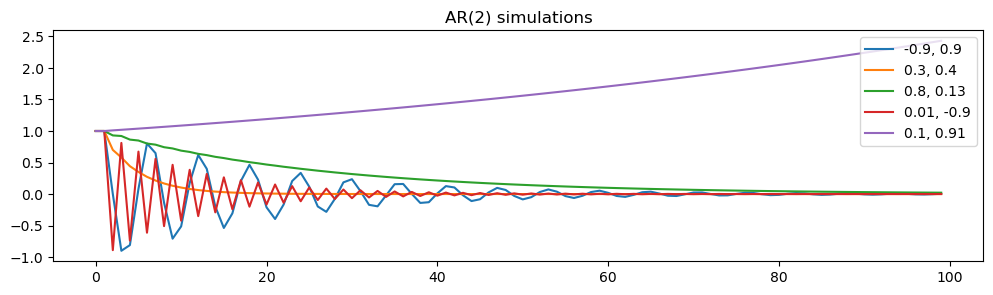

In [42]:
for i, arr in enumerate(lst_arrs):
    plt.plot(arr, label=f"{', '.join([str(i) for i in lst_As[i]])}")
plt.legend()
plt.title("AR(2) simulations")

# Question 8
"In VAR estimation, are the residuals supposed to be white noise or auto-regressive? What is the difference between weak white noise and strong white noise? Which are the null hypothesis and the statistics of the Ljung-Box or portmanteau test?"




In a VAR regression, the residuals are supposed to be white noise. If the residuals are autoregressive it would imply the VAR has been unsuccessful in extracting all the relationships between the variables and their lags. If the residuals were not white noise, a better order of VAR exists and the model could be estimated with greater explanatory power. If the residuals are autocorrelated, additional lags are added to the model. The number of lags can also be selected on the basis of the information criteria like AIC or SIC. 	No precautions are necessary if the residuals are correlated across equations

A key test for the VAR is to test whether there is autocorrelation in the residuals using a weak white noise test. Weak white noise requires that $\forall t, E(\epsilon_t)=0$, $Var(\epsilon_t)=\sigma^2_{\epsilon}$, $\forall t'≠t$,$Cov(\epsilon_{t}, \epsilon_{t'})=0$. Weak white noise residuals essentially means the residuals have constant variance, an expected value of 0 (mean 0) and for any two residuals, the covariance (and therefore correlation) is 0. By virtue of this, the residual at time t is not correlated with the residual at time t-1. Hence, no autocorrelation.

A strong white noise is a stochastic process of i.i.d. (identically, independently distributed) random variables. Strong white noise is a much stronger requirement than 0 covariance. The cumulative distribution function generating each observation must be identical and each lag must have a joint CDF with every other lag. Strong white noise imposes distributional assumptions over the whole history of the time series.

#### Ljung-Box Test
The null hypothesis of the Ljung-Box test is $H_0$: the data is independently distribution and the correlations are 0. If the residuals cannot reject the null hypothesis, the autocorrelation in the residuals is 0. This means that at a minimum the residuals are a white noise process. The alternative hypothesis $H_a$: The data is not independently distributed and there is autocorrelation in the residuals. A rejection of the null hypothesis of the Ljung-Box with regards to the residuals of a VAR model would imply the model is improperly specified and the lag length should be increased.






In VAR estimation, are the residuals supposed to be white noise or auto-regressive?
+ The resiudals are supposed to be white noise, if autocorrelated the VAR model does not fully capture the dynamics of the time series.
+ White noise residuals imply that the system of variables corresponds to the actual system generating the data in reality.

What is the difference between weak white noise and strong white noise? 
+ Weak white noise refers to uncorrelated variables, where correlation is a linear dependence as defined by the Pearson correlation coefficients. Consequently, weak white noise draws are linearily independent but may be linked through a non-linear function.
+ A stronger assumption is an indepednet identically distributed (iid) random white noise. Individual draws from such variable are independent of one another, thus there is no function linking the two. This explicitely includes non-linear functions, making this a stronger assumption than 1.

Which are the null hypothesis and the statistics of the Ljung-Box or portmanteau test?
+ The Ljung-Box statistic test for independence in the distribution



# Question 9

"DSGE models estimations add systematically auto-regressive shocks to each equation. They give a particular "insightful" name of each of these shocks (see Paul Romer critique of DSGE models). Half of these auto-regressive parameters turn to be estimated to be close to unit root using "Bayesian" estimation (see e.g. Smets and Wouters). Having unit root residuals: is it expected to be valid in VAR or VECM?"

Romer (2016) criticises DSGE models in their attribution of fluctuations in variables to imaginary forces. He even described sitting in with Ed Prescott, a founder of the Real Business Cycles model, on a student's oral, asking "What are these technology shocks?" and Ed Prescott replied "they're that traffic out there". Romer says the shocks are purely imaginary. He also criticises that the "sticky price lipstick on this RBC pig" allows for the possibility of monetary policy to affect output. He argues that macro models are far worse than they were when they relied on identification assumptions that did not hold, now the assumptions are no more credible and far more opaque.

The "insightful" names of the shocks are:
* a phlogiston (this is a substance that was believed to be in combustible bodies, like wood, that was only released when they were on fire. It is essentially the element that 'fire' is made of) that increases the quantity of consumption goods produced by given inputs
* an investment phlogiston that increases the quantity produced of capital goods
* a troll who makes random changes to the wages paid by all workers.
* a gremlin who makes random changes to the price of output
* Aether which increases the risk apetite of investors
* Caloric which makes people want less leisure.

DSGE modellers assume there is no way to measure these forces or shocks.

Having unit root residuals in a VAR model or a VECM model is not valid. Generally residuals should be stationary or white noise: random and uncorrelated over time. To test this the residuals can be plotted, the Ljung-Box test can be conducted on them, and the autocorrelation coefficients can be estimated.

Being white noise, the residuals should have 0 mean, be homoskedastic and have no autocorrelation. Having 0 mean is indicative of the model capturing the trend of the data. If the mean is non-zero then the model is under-estimating the data. Homoskedasticity is the condition that the variance of the residuals is constant. This means that at different time periods, the variance of the residuals is unchanged and the model is equally well estimated at all time periods. If there is autocorrelation in the residuals, it suggests that the autoregressive component of the VAR or VECM is not capturing all of the autocorrelation of the variables. As mentioned above, if there is autocorrelation remaining in the residuals after estimation, the order of the VAR should be increased.

Fulfilling these requirements means that what the model cannot explain (the residuals) is random. IF we find that the relationship between the variables could be changing over time, which might give rise to non-zero mean, heteroskedasticity or autocorrelation of the residuals, it might be that assuming constant parameter values over the full time period is too strict an assumption. For example, regressing inflation on interest rates over a 30-year period does not allow the capturing of all the unforeseen events or trends which may not have an influence on inflation or interest directly, but may affect the relationship between inflation and interest rates. Changing factors like increased globalisation, changing central bank governors or financial innovation might make the parameter values non-constant over time which can leave the model misidentified. This is the motivation for rolling window regressions which allows the setting of an estimation window which moves over time, allowing the relationship between variables to change and parameter values to be non-constant. 

In 'Publish and Perish' (Chatelain & Ralph, 2018), one of the reasons cited for the difficulty in testing macroeconomic theory relative to microeconomic theory is that the correlations between macroeconomic time series are not stable for periods longer than 10 to 20 years. Thi is caused by structural changes, as mentioned above, including changes in the rates of productivity and technological progress, changing exchange rate regimes, changes of regulations on capital flows and financial developments. Changes in political attitudes (e.g. Nixon to Reagan) can also change the transmission mechanisms.

# Question 10

"Based on question 4 and 5 and the paper "Publish and perish" in the reading list, would you expect 
* (1) observational equivalence of the DSGE auto-regressive shock assumption with an alternative specification
* (2) would you expect residuals to be unit root if there is already an auto-regressive term for the time series in the AR(1)- AR(1) model?
* (3) Would that suggest that some equations of DSGE model have no auto-regressive component for some dependent variables?"

Recall question 5:

The model results are:
|Autocorrelation parameter| Value| Autocorrelation of residual| value| 
|---|---|---|---|
|$\lambda_{\pi}$| $0.9927^{***}$|$\rho_{\pi}$|$0.2300^{***}$|
|$\lambda^{resid}_{\pi}$|$0.9834^{***}$|$\rho^{resid}_{\pi}$| $0.3063^{***}$|
|$\lambda_{i}$|$0.9964^{***}$| $\rho_{i}$| $-0.0711$|


So
$$
\pi_{t+1} = 0.9927\pi_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.2300u_t +\epsilon_{t+1} $$
and for the 'residual' inflation
$$
\pi^{resid}_{t+1} = 0.9834\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.3063u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = 0.9964i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = -0.0711u_t +\epsilon_{t+1} $$

Observational equivalence (Chatelain & Ralph, 2018) is where different models or specifications produce the same results and predictions. The narrative throughout Publish and Perish was centered around the emergence of DSGE modelling, replacing dominant theories of the 1980s. Researchers have an incentive to select observationally equivalent theories and forgetting discipline with respect to identification issues when using econometrics. Observational equivalence coupled with identification issues means that we cannot determine the underlying mechanisms the models try to predict. Obtaining equally precise predictions from multiple models, with different parameters, and different parameters identified, clouds the robustness of the theoretical foundations.

* We would expect observational equivalence of the DSGE auto-regressive shock assumption with an alternative specification. As shown in Section 4 of Publish and Perish, using the assumption that observable and unobservable exogenous variables follow a VAR(1), the solution is observationally equivalent to a VAR(1) where expectations are adaptive (based on all past information). "For any rational expectations DSGE model, there is an observationally equivalent adaptive expectations VAR model".

* If the AR(1)-AR(1) model is describing an AR(1)-AR(1) process, then there should not be a unit root in the residuals. Judging by the Ljung-Box text for the AR(1) models for the residuals, in all cases the null hypothesis of the data being independently distributed cannot be rejected (p-values > 0.10 for all). This suggests that despite the coefficients being statistically significant, there is no serial correlation of the residuals. Therefore, we would not expect the residuals to be unit root if there is already an autoregressive term for the time series in the AR(1)-AR(1) model as indicated by the results we obtained for the AR(1)-AR(1) models and the Ljung-Box statistics.

* It would seem to suggest that some equations of DSGE models have no autoregressive components for some dependent variables. DSGE models assume serially autocorrelated shocks, but we have shown with AR(1)-AR(1) models that there should not be correlation in the residuals or 'shocks' if an autocorrelation term is included. In Publish and Perish, the authors note that the auto-correlation of shocks can be replaced by adding lags of order two or more of observable variables, such as inflation, output gap and federal funds rate. This also suggests that there is not autoregressive component of the dependent variables. It also suggests that autoregressive components of order 2 are required, not just order 1 as we estimated with the AR(1)-AR(1) models.

# Question 11

"Estimate with 10 years rolling windows the auto-correlation coefficient of AR(1) for the policy instrument and the policy target. Plot estimates over time. Do you distinguish different periods for distinct values of persistence: unit root or stationary process?"

Recall the AR(1) models we are estimating.
$$
\pi^{resid}_{t+1} = \lambda^{resid}_{\pi}\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho^{resid}_{\pi}u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = \lambda_{i}i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho_{i}u_t +\epsilon_{t+1} $$

Using 10 year rolling windows will generate a dataset of parameter values beginning 10-years after the first observation. In other words, we will have parameter values as a dataset monthly, beginning the 60th month after the dataset begins. This is because the models above are estimated, generating parameter values for a given date, using data for all 60 observations prior to that date.

In [43]:
sub = df[['pi_Y_resid', 'ir']].dropna().copy()

In [44]:
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
window = 12*10

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)][:]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}
    
    for col in sub:
        ar = ARIMA(sub.iloc[eow-window : eow][col], order=(1,0,0)).fit()
        dict_coefs[eow][col] = ar.params['ar.L1']
        
        adf, pval, _, _, _, _ = adfuller(sub.iloc[eow-window:eow][col], )
        if pval > .05:
            dict_unit_root[eow][col] = True
        else:
            dict_unit_root[eow][col] = False
            

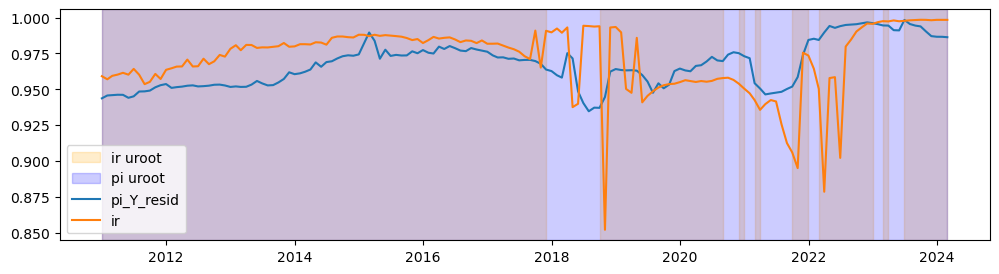

In [45]:
df_uroot = pd.DataFrame(dict_unit_root).T #columns=sub.iloc[window:].index).T
df_coefs = pd.DataFrame(dict_coefs).T #, columns=sub.iloc[window:].index).T

#making the index and x-axis more readable
start_date = sub.index[0]  # This should be the starting date of your dataframe
offset = pd.DateOffset(months=120)  # Offset by 120 months
start_date_offset = start_date + offset
new_index_dates = pd.date_range(start=start_date_offset, periods=len(df_coefs), freq='M')
df_coefs.index = new_index_dates

_ = (((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0 ) + ( ((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0) 
df_uroot += _

#for u_root
df_uroot.index = new_index_dates

fig, ax = plt.subplots(1,1)
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 1], alpha=.2, transform=ax.get_xaxis_transform(), label='ir uroot', color = 'orange')
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 0], alpha=.2, transform=ax.get_xaxis_transform(), label='pi uroot', color = 'blue')
for col in df_coefs:
    plt.plot(df_coefs.index, df_coefs[col], label=col)
plt.legend()

As we saw in class, especially for inflation, if the process has an AR(1) root, then it is on or has crossed a bifurcation boundary, making the process unstable. We might expect this to occur during times of high inflation. While we would not expect this in the Euro area, hyperinflation is a period where the observed high inflation leads agents to bring forward purchases of goods, services, capital and inputs, increasing inflation further. This is what 'explosive' inflation is. Throughout the time series, for the 10-year rolling window, the AR(1) coefficient never exceeds 1. This suggests the process is not explosive.

A unit root implies that the process is non-stationary, it is not white noise. For the process to have a unit root, it means there is persistence and dependence on past values. 

For interest rates, there is presence of a unit root from 2012 to late 2017 of our sample. After late 2018, the unit root of interest rates phases in and out. This suggests a regime change with interest rates having higher persistence on previous values, this is despite the volatility of the AR(1) parameter. It suggests that shocks are more permanent and reversion back to the trend takes a longer period of time. For interest rates this makes sense. It suggests that an increase in interest rates has greater persistence, and interest rates tend to be more stable over time. I would have expected there to be a break in the unit root around the COVID period/end of the pandemic when interest rates were changing by large amounts, and we can see the volatility in the AR(1) parameter that reflects this around the 2021 period. The sovereign debt crisis was nearing the end in 2015, with Greece's economic outlook improving amid lower unemployment in 2015 and improved economic growth in 2014. This could have signaled a change for the ECB, stabilising interest rates, resulting in higher persistence and a unit root. It is more common for interest rates to have a unit root than inflation (Rose, 1988).

For inflation, a unit root is more worrying because it signals a tendency for shocks to have more of a lasting effect on the economy. Having a unit root means that an inflationary shock, like to oil prices in 2022 which indirectly affects CPI, has a lasting effect. The presence of a unit root for inflation is more black-and-white. There is clear indication of a regime change. From 2015 to the end of our parameter sample in early this year

Inflation's coefficient is much more stable than interest rates. The AR(1) coefficient for inflation varies between the minimum of 0.93 and the maximum of 0.99 with a standard deviation of 0.014. Interest rates on the other hand varies between 0.85 and 0.99 with a standard deviation of 0.02. The minimum value of 0.85 suggests that there was a period of inflation where there were more rapid changes in interest rates.

It is interesting to note that both appear to go through 'regime changes'. Although our data length is limited, interest rates have an entire period characterised by a unit root, the regime changes, and the unit root switches in and out. For inflation, it is no unit root, then all unit root. It suggests that in 2015 the behaviour of inflation or the inflationary drivers changed. We know that the period up to around 2018 was characterised by low and very stable inflation, and perhaps with the end of the sovereign debt crisis in 2015. In 2015, the ECB announced quantitative easing asset purchase programmes. This may have influenced the persistence of inflation. It could be the case that inflationary expectations became more rigid with the ECB taking a more interventionist approach to the economy (Andrade et al., 2016). In 2014 and 2015 there was also a sharp decline in oil prices. Oil prices indirectly influence the CPI through manufacturing and transportation costs, this decline could have contributed to persistence in inflation because the source of inflation may have been more stable demand-side factors (World Bank, 2018).

In [46]:
df_coefs.dropna().describe()

,pi_Y_resid,ir
count,159.000000,159.000000
mean,0.967199,0.971381
std,0.015726,0.023591
min,0.934679,0.852072
25%,0.952805,0.957559
50%,0.968752,0.979665
75%,0.976792,0.986803
max,0.998345,0.998457


In [47]:
df_coefs_AR = df_coefs.copy()

# Question 12

"Estimate three years rolling windows of the deterministic trend equation for the policy target. Plot time-varying estimates of the trend g parameter as a function of time:
$
ln(\pi_{t+1}) = a + gt + \epsilon
$      "

In [48]:
sub_ = df[['pi_Y_resid', 'ir']].dropna().copy()
sub_['pi_Y_resid'] = np.log(sub_.pi_Y_resid + abs(sub_.pi_Y_resid.min()) + .01)
sub_ = sm.add_constant(sub_)

In [49]:
sub_

,const,pi_Y_resid,ir
2000-12-01,1.0,-3.170333,0.056877
2001-01-01,1.0,-3.282893,0.056982
2001-02-01,1.0,-3.288414,0.053482
2001-03-01,1.0,-3.244475,0.051061
2001-04-01,1.0,-3.126428,0.051120
...,...,...,...
2023-10-01,1.0,-3.100840,0.056597
2023-11-01,1.0,-3.212228,0.056395
2023-12-01,1.0,-3.090411,0.056274
2024-01-01,1.0,-3.122763,0.055811


In [50]:
window = 12*3

dict_coefs_ = {}
for eow in [*range(window, len(sub_),1)][:]:
    dict_coefs_[eow] = {}
    s = sub_.iloc[eow-window : eow].copy()
    s['trend'] = [*range(window)]
    
    for col in sub_.drop('const', axis=1):
        ols = OLS(s[col], exog=s[['const', 'trend']]).fit()
        dict_coefs_[eow][col] = dict(ols.params)

Trend


<Axes: >

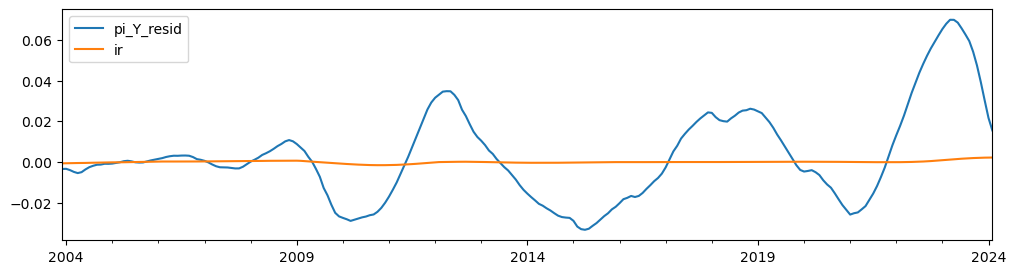

In [51]:
print('Trend')
df_coefs_ = pd.DataFrame({key: {k: value[k]['trend'] for k in value.keys()} for key, value in dict_coefs_.items()}).T
start_date = sub.index[0]  # This should be the starting date of your dataframe
offset = pd.DateOffset(months=window)  # Offset by 120 months
start_date_offset = start_date + offset
new_index_dates = pd.date_range(start=start_date_offset, periods=len(df_coefs_), freq='M')
df_coefs_.index = new_index_dates
df_coefs_.plot()

The Figure above plots the evolution of the parameter $g$ in the model $ln(\pi_{t+1}) = a + gt + \epsilon$ using three year rolling windows. This should show how inflation responds to the passing of time. In other words, it should show the evolution of trend inflation over time, ceteris paribus (if g is correctly identified). What we observe is cyclicality. Prior to the financial crisis, inflation was very stable over time, exhibitng no cyclicality and the trend was stable. The coefficient on trend, g, is 0 prior to the financial crisis, suggesting inflation was stable and invariant to the passing of time - there is no trend of inflation. Following the financial crisis, and certainly after covid, the parameter g fluctuates between the positive and negative, reflecting increases and decreases in inflation over time. g increases rapidly in 2021 following the early stages of the COVID crisis, increasing more rapidly in 2022 following Russia's invasion of Ukraine and the rapid inflation that followed. Interestingly, despite these crises, the cyclicality of the trend of inflation is preserved. Indeed, the estimations with the window creeping into 2024 shows a decline in the trend.

It is worth mentioning what g actually shows. Because we are using a log-level model, a one unit increase in time, t, increases inflation by $g*100%$. This means that a coefficient of 0.02, for example, means that from t=1 to t=2, and t=2 to t=3, etc over the window monthly annualised inflation increases by 2%. Rather, for a given g, over the 3 year period up to and including the date of the estimated g, inflation is expected to increase by $g*100%$.

Detrending would involve using the residuals of this time series, removing the cyclicality, which is given by $\epsilon$.

With regards to interest rates, there is not much to observe. There appears to be no cyclicality of interest rates, reflected by the figure and the summary statistics below. The mean is negligibly different from 0.

In [52]:
df_coefs_.describe()

,pi_Y_resid,ir
count,243.000000,243.000000
mean,0.002875,-0.000058
std,0.022783,0.000625
min,-0.033380,-0.001622
25%,-0.013479,-0.000253
50%,-0.000175,-0.000067
75%,0.015697,0.000107
max,0.069870,0.002137


The mean value of $g$ for inflation is also close to 0, but fluctuates between the positive and negative. Notably, the median is also nearly 0, suggesting that inflation fluctuates between the positive and negative in the same fashion and appears to be a mean reverting process. The standard deviation for $g$ for inflation far exceeds that of the interest rates which is to be expected given the cyclical nature.

Constants


<Axes: >

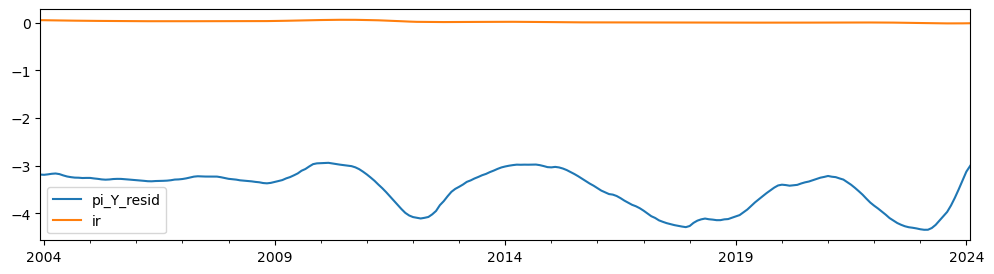

In [53]:
print('Constants')
df_consts_ = pd.DataFrame({key: {k: value[k]['const'] for k in value.keys()} for key, value in dict_coefs_.items()}).T
df_consts_.index = new_index_dates
df_consts_.plot()

The constant, $a$, is fairly stable over time, varying slightly with cyclicality, suggesting the underlying constant level of inflation is increasing and decreasing as the window moves.

# Question 13

"For unit root periods (auto-correlation close to one) of the policy target, if you notice on the graph of the time series a rising trend subperiod and estimate a determenistic trend on this subperiod: $ln(\pi_{t+1}) = a + gt + \epsilon$ $ (g > 0)$. Do the same if you notice a subperiod with declining trend: $ln(\pi_{t+1}) = a + gt + \epsilon$ $ (g < 0)$.

($E_0\pi_{t+1}=(1+g)^t\pi_0$ implies $ln(E_0\pi_{t+1}=ln(\pi_0)+tln(1+g) = ln(\pi_0)+gt$ if $g$ is small)."


# Question 14

"Test for unit roots for policy instrument and target (on distinct periods if shifts of stationarity). Comment the results."

In [54]:
sub = df[['pi_Y_resid', 'ir']].copy().dropna()

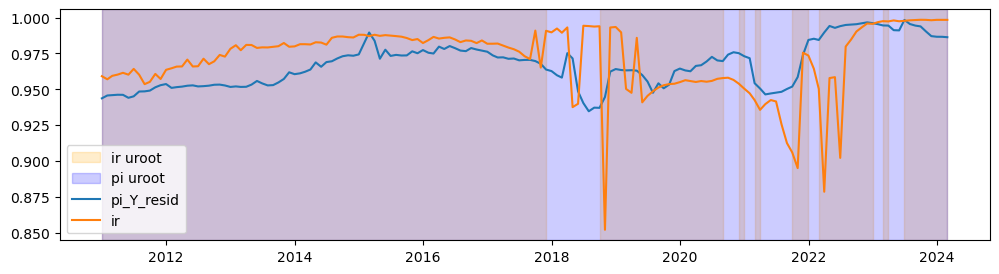

In [55]:
fig, ax = plt.subplots(1,1)
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 1], alpha=.2, transform=ax.get_xaxis_transform(), label='ir uroot', color = 'orange')
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 0], alpha=.2, transform=ax.get_xaxis_transform(), label='pi uroot', color = 'blue')
for col in df_coefs:
    plt.plot(df_coefs.index, df_coefs[col], label=col)
plt.legend()

The plot in question 12 displays the Dickey fuller test results for presence of a unit root. The blue shaded area indicates presence of a unit root for inflation (non-stationarity) and the yellow shaded area indicates non-stationarity for interest rates. There is clear shifts of stationarity. As mentioned above, there is only a short period of overlap where both inflation and interest rates both have a unit root, indicated by a failure to reject the null hypothesis of the Dickey-Fuller test. We can see that interest rates have a unit root up until 2018, where they become stationary (no dependence on past values) and phase in and out of stationarity following this. The phasing in and out could indicate periods of rapid changes followed by periods of stability. Rapid changes indicate less dependence/persistence on past values and could lead to a rejection of the null hypothesis of the Dickey-Fuller test. 

For inflation, the shift in regime is more obvious. Inflation rates appear to be stationary before 2015, and then non-stationary after 2015. This suggests inflation became more persistent following 2015, perhaps explained by oil price shocks and the recovery from the sovereign debt crisis as mentioned above.

In [56]:
for col in sub:
    print(adf_test_summary(sub[col]))

-----------------------------------------------------------------------------
ADF Test PI_Y_RESID: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.827    0.367  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.941    0.633  12.0  266.0 -3.993 -3.427 -3.137
constant ltend, qtrend    -2.888    0.351  12.0  266.0 -4.415 -3.855 -3.567
none                      -1.862    0.060  12.0  266.0 -2.574 -1.942 -1.616


None
-----------------------------------------------------------------------------
ADF Test IR: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.906    0.329   6.0  272.0 -3.455 -2.872 -2.572
constant trend            -1.236    0.903   6.0  272.0 -3.992 -3.42

The ADF test tests presence of a unit root across the entire sample. For inflation, p-values greater than 0.05 mean we fail to reject the null hypothesis that there is a unit root. This means that over the entire sample, there is dependence on past values. The same can be said for interest rates.

## Q15 cross correlation

In [57]:
sub = df[['pi_Y_resid', 'ir']].dropna().copy()

In [58]:
sub

,pi_Y_resid,ir
2000-12-01,0.004329,0.056877
2001-01-01,-0.000141,0.056982
2001-02-01,-0.000348,0.053482
2001-03-01,0.001328,0.051061
2001-04-01,0.006213,0.051120
...,...,...
2023-10-01,0.007350,0.056597
2023-11-01,0.002606,0.056395
2023-12-01,0.007822,0.056274
2024-01-01,0.006374,0.055811


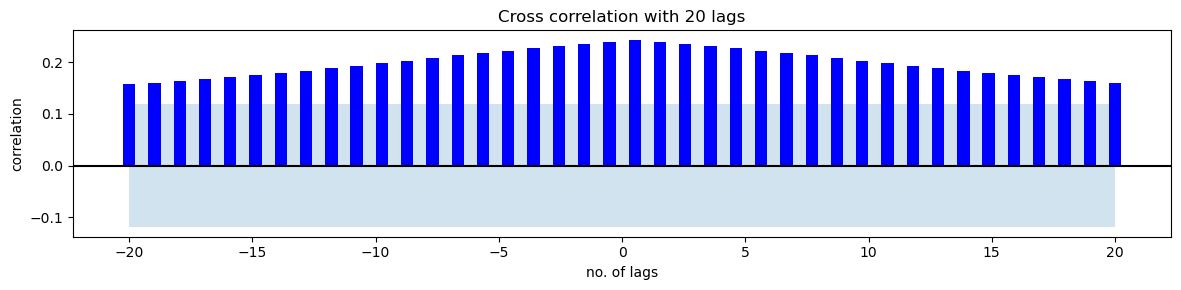

In [59]:
idx, corr, _, _, _ = cross_corr(sub.iloc[:,0], sub.iloc[:,1], lags=20)

In [60]:
pd.DataFrame(corr, index=idx);

# Question 16

Using 10 years rolling windows of the estimation of the fist order single input single output model (estimate also the auto-correlation of order one of the residuals for each equation):

$\pi_{t+1} = A\pi_t + Bi_t +u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

$i_{t+1} = F\pi_t + u_{t+1}$ with $ u_{t+1} =\rho u_{t} + \epsilon_{t+1}$

In [171]:
sub = df[['pi_Y_resid', 'ir']].dropna().copy()
sub = sub.join(sub.shift(-1).add_suffix('_lead1')).dropna()

In [172]:
window = 12*10

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}

    s = sub.iloc[eow-window : eow]
    # s = sm.add_constant(s)
    
    ols_pi = OLS(endog=s['pi_Y_resid_lead1'], exog=s[['pi_Y_resid', 'ir']], hasconst=None).fit()
    ols_i = OLS(endog=s['ir_lead1'], exog=s[['pi_Y_resid',]], hasconst=None).fit()
    dict_coefs[eow].update(dict(zip(['A', 'B'], ols_pi.params)))
    dict_coefs[eow].update(dict(zip(['F'], ols_i.params)))

    ar_pi = ARIMA(ols_pi.resid, order=(1,0,0), trend='n').fit()
    ar_i = ARIMA(ols_i.resid, order=(1,0,0), trend='n').fit()
    dict_coefs[eow].update(dict(zip(['rho_pi_u', 'sig_pi_u'], ar_pi.params)))
    dict_coefs[eow].update(dict(zip(['rho_ir_u', 'sig_ir_u'], ar_i.params)))

    dict_coefs[eow]['B_se'] = ols_pi.bse['ir']

    # Calculate confidence intervals
    dict_coefs[eow]['B_lower'] = dict_coefs[eow]['B'] - 1.96 * dict_coefs[eow]['B_se']
    dict_coefs[eow]['B_upper'] = dict_coefs[eow]['B'] + 1.96 * dict_coefs[eow]['B_se']


    ar_pi_lamb = ARIMA(s['pi_Y_resid'], order=(1,0,0)).fit()
    dict_coefs[eow].update(dict(zip(['pi_lambda'], ar_pi_lamb.params)))
    
    for col in [('pi', 'pi_Y_resid'), ('ir', 'ir')]:
        adf, pval, _, _, _, _ = adfuller(s[col[1]],)
        dict_coefs[eow].update({f'uroot_{col[0]}': pval > .05})


In [173]:
df_coefs = pd.DataFrame(dict_coefs).T
df_coefs.index = sub.index[window:]

In [174]:
uroot = df_coefs[['uroot_pi', 'uroot_ir']].copy()
uroot += (((uroot+1)- (uroot.shift(-1)+1)) != 0 ) + ( ((uroot+1)- (uroot.shift(-1)+1)) != 0) 
df_coefs[['uroot_pi', 'uroot_i']] = uroot

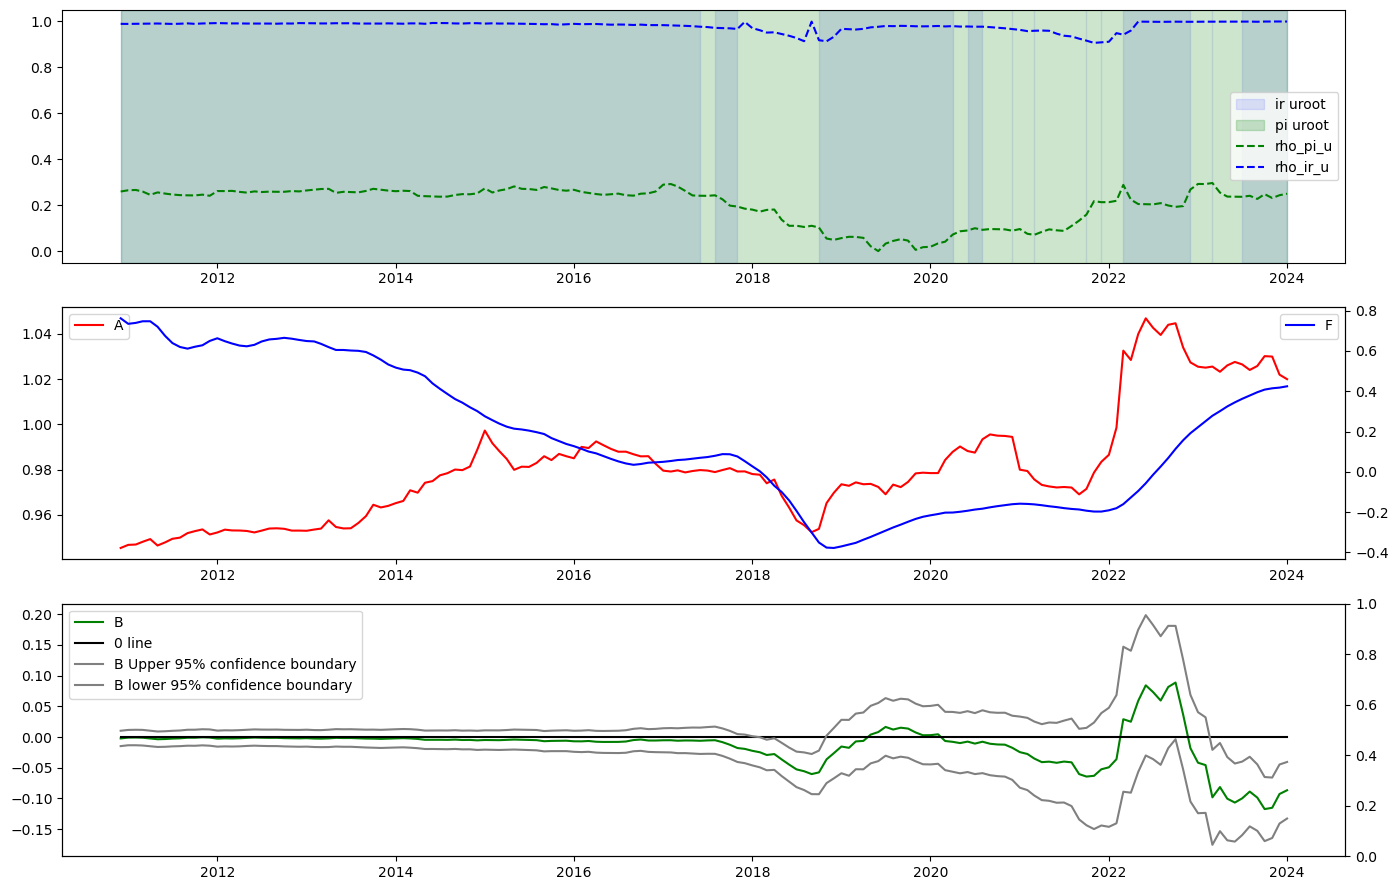

In [175]:
fig, ax = plt.subplots(3, 1, figsize=(14,9))  # Adjusting for three subplots

# First subplot (unchanged)
ax[0].fill_between(df_coefs.index, 0, 1, where=df_coefs.uroot_ir, alpha=.1,
                   transform=ax[0].get_xaxis_transform(), color='blue', label='ir uroot')
ax[0].fill_between(df_coefs.index, 0, 1, where=df_coefs.uroot_pi, alpha=.2, 
                   transform=ax[0].get_xaxis_transform(), color='green', label='pi uroot')
ax[0].plot(df_coefs.rho_pi_u, label='rho_pi_u', color='green', linestyle='dashed')
ax[0].plot(df_coefs.rho_ir_u, label='rho_ir_u', color='blue', linestyle='dashed')
ax[0].legend()

# Second subplot (only A and F)
ax[1].plot(df_coefs.index, df_coefs.A, label='A', color='red')
ax12 = ax[1].twinx()
ax12.plot(df_coefs.index, df_coefs.F, label='F', color='blue')
ax[1].legend(loc='upper left')
ax12.legend(loc='upper right')

# Third subplot (B, zero line, confidence interval)
ax11 = ax[2].twinx()
ax[2].plot(df_coefs.index, df_coefs.B, label='B', color='green')
ax[2].plot(df_coefs.index, np.zeros(len(df_coefs)), label='0 line', color='black')  # Zero line
#ax[2].fill_between(df_coefs.index, df_coefs.B_lower, df_coefs.B_upper, color='green', alpha=0.3, label='95% CI for B')
ax[2].plot(df_coefs.index, df_coefs.B_upper, label='B Upper 95% confidence boundary', color='grey')
ax[2].plot(df_coefs.index, df_coefs.B_lower, label='B lower 95% confidence boundary', color='grey')
ax[2].legend(loc='upper left')

fig.tight_layout()
plt.show()


In [176]:
df_coefs_Q16 = df_coefs.copy()
df_coefs_Q16.index = sub.index[window:]
df_coefs_Q16 = df_coefs_Q16.join(sub['pi_Y_resid'])

In [177]:
df_coefs[['B', 'A', 'F', 'rho_pi_u', 'rho_ir_u']] = df_coefs[['B', 'A', 'F', 'rho_pi_u', 'rho_ir_u']].apply(pd.to_numeric, errors='coerce')
df_coefs[['B', 'A', 'F', 'rho_pi_u', 'rho_ir_u']].describe()

,B,A,F,rho_pi_u,rho_ir_u
count,158.000000,158.000000,158.000000,158.000000,158.000000
mean,-0.013768,0.980716,0.171974,0.201123,0.978176
std,0.033355,0.024847,0.339488,0.081669,0.021396
min,-0.117263,0.945353,-0.378213,-0.000273,0.905242
25%,-0.019033,0.963445,-0.164743,0.133418,0.973921
50%,-0.005290,0.978674,0.107139,0.242212,0.987766
75%,-0.002077,0.988146,0.501498,0.259388,0.990110
max,0.088612,1.046902,0.762103,0.296001,0.998380


Here we can observe the 'price puzzle'. With these models:
$\pi_{t+1} = A\pi_t + Bi_t +u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$ and $i_{t+1} = F\pi_t + u_{t+1}$ with $ u_{t+1} =\rho u_{t} + \epsilon_{t+1}$
economic theory would suggest that A would be positive (showing persistence of inflation), F should be positive and measures the responsiveness of the central bank to inflation. B should be negative. If we observe interest rates going up in one period, we should see inflation decline in the next (possibly the next, likely to be more of a delayed effect though'. Hence B should be negative reflecting the inverse relationship between inflation and interest rates. If B is positive or 0 then monetary policy is a lie! Why do we have central banks increasing interest rates only for inflation to go up or not change at all. This is observed here.

Historical data shows a positive relationship between inflation and the policy rate (Balke & Emery, 1994). The strength of the positive relationship between inflation and interest rates is not uniform over time. This is an observation documented in the literature and is also visible in the above graph. For the US, relationships that held in the 1960s and 1970s broke down in the 1980s (Balke & Emery, 1994). The salience of the price puzzle is not constant, with some period being 'more puzzling' with higher positive Bs than others. Due to the length and period of our data, we cannot distinguish effectively these changes in price puzzle regimes. We can see a shift following COVID and the end of the period of relative tranquility following the financial crisis where rates were low and stable and inflation was equally low and stable. This explains why the coefficient for B is practically 0 here with the confidence boundary enveloping the B=0 line. The lack of variation in inflation and rates means that the parameter B cannot be identified as being different from 0. This changes towards the end of our sample however. In 2023, the value of B is statistically significant and negative, refuting evidence of the 'prize puzzle' but this is a very small snapshot of the entire sample. For almost all of the sample, B is not statistically different from 0 and is positive between 2022 and 2023. Perhaps with a longer time period we would be able to observe the prize puzzle better.

Some of the explanations of the price puzzle are sensible. One is that central banks raise interest rates when signals suggest inflation is rising. With monthly data, this would suggest that B is positive because inflation does not have time to respond and central banks are pre-emptively increasing rates (Balke & Emery, 1994). Another explanation is that rates rise to offset supply shocks but not by enough to prevent the aggregate price level rising (Balke & Emery, 1994).

The price puzzle is argued to have moderated since the 1980s which explains the results of our models. Balke and Emery (1994) suggest two reasons:
* Central Banks have put more emphasis on achieving price stability and so are more responsive to shocks (explains B being positive)
* There have been fewer inflationary shocks to respond to (explains B being 0). 

Below I estimate the same models but with just a 12 month rolling window. Here the prize puzzle is perhaps more visible, with B switching between the positive and negative with a greater frequency.

In [68]:
window = 12

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}

    s = sub.iloc[eow-window : eow]
    # s = sm.add_constant(s)
    
    ols_pi = OLS(endog=s['pi_Y_resid_lead1'], exog=s[['pi_Y_resid', 'ir']], hasconst=None).fit()
    ols_i = OLS(endog=s['ir_lead1'], exog=s[['pi_Y_resid',]], hasconst=None).fit()
    dict_coefs[eow].update(dict(zip(['A', 'B'], ols_pi.params)))
    dict_coefs[eow].update(dict(zip(['F'], ols_i.params)))

    ar_pi = ARIMA(ols_pi.resid, order=(1,0,0), trend='n').fit()
    ar_i = ARIMA(ols_i.resid, order=(1,0,0), trend='n').fit()
    dict_coefs[eow].update(dict(zip(['rho_pi_u', 'sig_pi_u'], ar_pi.params)))
    dict_coefs[eow].update(dict(zip(['rho_ir_u', 'sig_ir_u'], ar_i.params)))

    dict_coefs[eow]['B_se'] = ols_pi.bse['ir']

    # Calculate confidence intervals
    dict_coefs[eow]['B_lower'] = dict_coefs[eow]['B'] - 1.96 * dict_coefs[eow]['B_se']
    dict_coefs[eow]['B_upper'] = dict_coefs[eow]['B'] + 1.96 * dict_coefs[eow]['B_se']


    ar_pi_lamb = ARIMA(s['pi_Y_resid'], order=(1,0,0)).fit()
    dict_coefs[eow].update(dict(zip(['pi_lambda'], ar_pi_lamb.params)))
    
    for col in [('pi', 'pi_Y_resid'), ('ir', 'ir')]:
        adf, pval, _, _, _, _ = adfuller(s[col[1]],)
        dict_coefs[eow].update({f'uroot_{col[0]}': pval > .05})

In [69]:
df_coefs_ = pd.DataFrame(dict_coefs).T
df_coefs_.index = sub.index[window:]

In [70]:
uroot = df_coefs_[['uroot_pi', 'uroot_ir']].copy()
uroot += (((uroot+1)- (uroot.shift(-1)+1)) != 0 ) + ( ((uroot+1)- (uroot.shift(-1)+1)) != 0) 
df_coefs_[['uroot_pi', 'uroot_i']] = uroot

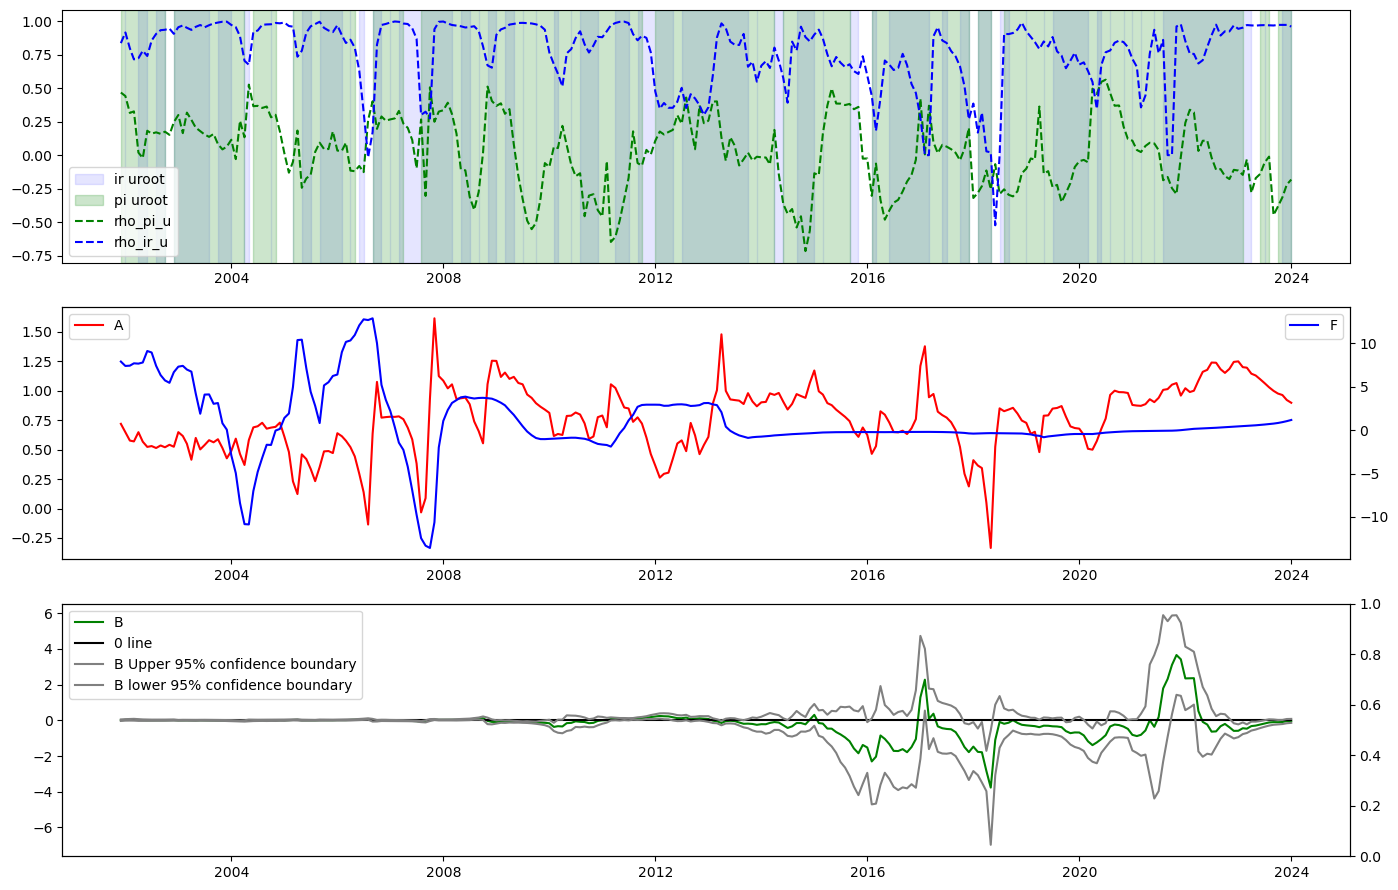

In [71]:
fig, ax = plt.subplots(3, 1, figsize=(14,9))  # Adjusting for three subplots

# First subplot (unchanged)
ax[0].fill_between(df_coefs_.index, 0, 1, where=df_coefs_.uroot_ir, alpha=.1,
                   transform=ax[0].get_xaxis_transform(), color='blue', label='ir uroot')
ax[0].fill_between(df_coefs_.index, 0, 1, where=df_coefs_.uroot_pi, alpha=.2, 
                   transform=ax[0].get_xaxis_transform(), color='green', label='pi uroot')
ax[0].plot(df_coefs_.rho_pi_u, label='rho_pi_u', color='green', linestyle='dashed')
ax[0].plot(df_coefs_.rho_ir_u, label='rho_ir_u', color='blue', linestyle='dashed')
ax[0].legend()

# Second subplot (only A and F)
ax[1].plot(df_coefs_.index, df_coefs_.A, label='A', color='red')
ax12 = ax[1].twinx()
ax12.plot(df_coefs_.index, df_coefs_.F, label='F', color='blue')
ax[1].legend(loc='upper left')
ax12.legend(loc='upper right')

# Third subplot (B, zero line, confidence interval)
ax11 = ax[2].twinx()
ax[2].plot(df_coefs_.index, df_coefs_.B, label='B', color='green')
ax[2].plot(df_coefs_.index, np.zeros(len(df_coefs_)), label='0 line', color='black')  # Zero line
#ax[2].fill_between(df_coefs_.index, df_coefs_.B_lower, df_coefs_.B_upper, color='green', alpha=0.3, label='95% CI for B')
ax[2].plot(df_coefs_.index, df_coefs_.B_upper, label='B Upper 95% confidence boundary', color='grey')
ax[2].plot(df_coefs_.index, df_coefs_.B_lower, label='B lower 95% confidence boundary', color='grey')
ax[2].legend(loc='upper left')

fig.tight_layout()
plt.show()


# Question 17

"Using 10 years rolling windows, compute A + BF and compare it to your AR(1) estimate $\lambda_\pi$ of inflation"

The original AR(1) estimate of inflation:
$$
\pi^{resid}_{t+1} = 0.9834\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.3063u_t +\epsilon_{t+1} $$

In [115]:
window = 12 * 10
coefficients = [] 
sub.dropna(subset=['pi_Y_resid', 'pi_Y_resid_lead1'], inplace=True)

for start in range(len(sub) - window + 1):
    end = start + window
    y = sub['pi_Y_resid_lead1'].iloc[start:end]
    X = sub['pi_Y_resid'].iloc[start:end]
    model = OLS(y, X, hasconst=False).fit()
    coefficients.append(model.params[0])

df_coefs['lamb'] = pd.Series(coefficients, index=sub.index[window - 1:])


/var/folders/09/xzm4y09n6rd6zqfv2hg1q3xw0000gn/T/ipykernel_3958/2540141988.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.append(model.params[0])


In [116]:
df_coefs[['A', 'B', 'F', 'A+BF', 'lamb']].head(3)

,A,B,F,A+BF,lamb
2010-12-01,0.945353,-0.002317,0.762103,0.943587,0.946051
2011-01-01,0.946718,-0.000970,0.734733,0.946005,0.946305
2011-02-01,0.946876,-0.000826,0.739403,0.946266,0.947290


In [117]:
df_coefs['A+BF'] = df_coefs['A'] + df_coefs['B'] * df_coefs['F']

<Axes: >

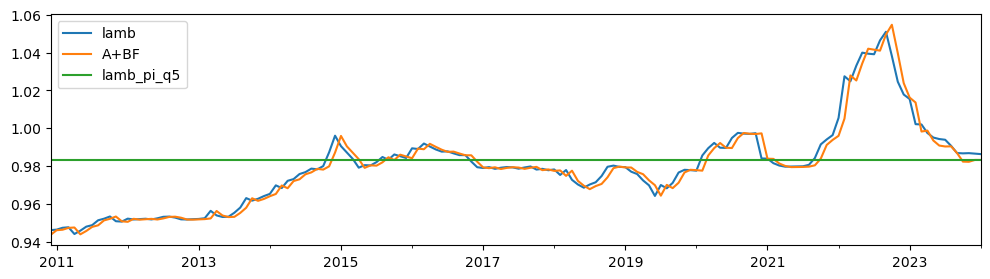

In [118]:
lamb_pi_q5 = 0.9834
df_coefs['lamb_pi_q5'] = lamb_pi_q5
df_coefs[['lamb', 'A+BF', 'lamb_pi_q5']].plot()

In [119]:
df_coefs[['lamb', 'A+BF', 'lamb_pi_q5']].describe()

,lamb,A+BF,lamb_pi_q5
count,158.000000,158.000000,1.580000e+02
mean,0.979473,0.978885,9.834000e-01
std,0.021514,0.021829,1.113753e-16
min,0.943993,0.943587,9.834000e-01
25%,0.968239,0.965832,9.834000e-01
50%,0.979417,0.979188,9.834000e-01
75%,0.987722,0.987406,9.834000e-01
max,1.051088,1.054794,9.834000e-01


$\pi_{t+1} = (A+BF)\pi_t + u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

$\pi_{t+1} = \lambda_{\pi}\pi_{t} + u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

On the plot above, we have the AR(1) lamb_pi_q5 from question 5, which is equal to 0.9834. We also have the A+BF from the 10-year rolling window estimations in the previous question. I have also estimated the AR(1) lamb using a 10-year rolling window and plotted it on the figure also. A+BF does not exceed the lambda from question 5 in mean because the mean is 0.979 which is slightly less than 0.983. Comparing to the lamda estimated using 10-year rolling windows (AR(1) coefficient) A+BF is almost exactly the same both in mean and behaviour throughout the sample. This suggests that instrumenting for inflation using interest rates with the two-equation model:
$\pi_{t+1} = A\pi_t + Bi_t +u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

$i_{t+1} = F\pi_t + u_{t+1}$ with $ u_{t+1} =\rho u_{t} + \epsilon_{t+1}$

is largely successful.

For most of the period A+BF is less than the full-sample lambda from question 5. In 2015 A+BF exceeds the value but this is short-lived, dropping below again until 2020 and 2022. During 2022, A+BF is greater than the full sample AR(1) coefficient for inflation.

Also observable from the graph is the lambda exceeding A+BF for most of the sample suggesting that A+BF should be less than A for the next question.

# Question 18

"Plot A, B, F , A+BF for rolling windows on the same graph. How is this comparison related to the Lucas critique ? Regarding the signs of estimates of B and F, do you conclude to positive feedback or negative feedback (0 < A + BF < A) taking into account the estimated values of the policy rule parameter?"

<Figure size 1500x1000 with 0 Axes>

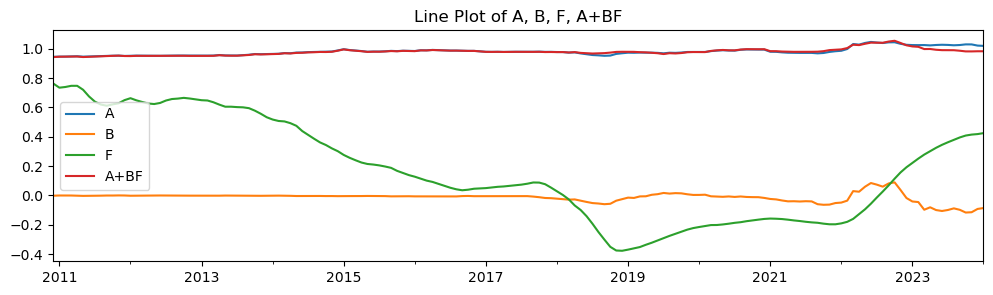

In [120]:
plt.figure(figsize=(15, 10)) 
df_coefs[['A', 'B', 'F', 'A+BF']].plot(kind='line')
plt.title('Line Plot of A, B, F, A+BF')
plt.legend()
plt.show()

$\pi_{t+1} = A\pi_t + Bi_t +u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

$i_{t+1} = F\pi_t + u_{t+1}$ with $ u_{t+1} =\rho u_{t} + \epsilon_{t+1}$

The Lucas critique says that it is naive to try to predict the effects of changes in economic policy on the basis of relationships obsevred in historical data. It is related to Goodhart's law which states that when a measure becomes a target it ceases to be a good measure. Both emphasise the need to consider changes in people's behaviour in response to new policies. 

The Lucas critique might show itself in the data if F is large (indicating the CB takes inflation very seriously) but B is low or A is high. What this means is that the central bank may take inflation seriously, F may increase, but this increase may be cancelled out by greater persistence of inflation (through A) or a lower responsiveness of inflation to the policy rate, B. In other words, the actual persistence of inflation (A+BF) could just stay the same. 

The Lucas critique is relevant for activist monetary policy and suggests that having a high F might not actually do anything. The economy/agents may respond to this, internalising the stance of the central bank, adjusting their behaviour and cancelling out the effect. Although this graph is not incredibly well proportioned with B being so small and A+BF being close to 1 making the movements of the series appear slight, it is immediately visible that A+BF tends to be stable at around 1. In fact, despite huge fluctuations in F (the central bank's stance), A+BF does not reflect this because B is so low. Despite F fluctuating from 0.8 to below 0, A+BF hardly deviates from its mean at all.

We can also see that as F decreases in 2019, B actually increases a bit, which suggests there is a bit of this cancelling out effect. Nevertheless, B is so close to 0 the value of F does not matter that much when it is between 1 and -0.4.

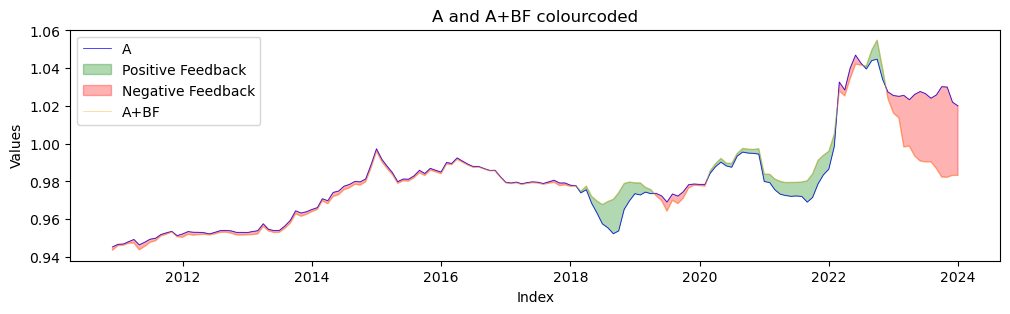

In [95]:
plt.plot(df_coefs.index, df_coefs['A'], label='A', color='blue', linewidth=0.5)
plt.fill_between(df_coefs.index, df_coefs['A'], df_coefs['A+BF'], where=df_coefs['A+BF'] >= df_coefs['A'], 
                 interpolate=True, color='green', alpha=0.3, label='Positive Feedback')
plt.fill_between(df_coefs.index, df_coefs['A'], df_coefs['A+BF'], where=df_coefs['A+BF'] < df_coefs['A'], 
                 interpolate=True, color='red', alpha=0.3, label='Negative Feedback')

plt.plot(df_coefs.index, df_coefs['A+BF'], label='A+BF', color='orange', alpha=0.5, linewidth=0.5)

plt.title('A and A+BF colourcoded')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


Negative feedback is where $0<A+BF<A$. If this is true, the central bank's actions are dampening the persistence of inflation. In other words, it means that the product of B and F is negative. So, if the central bank takes inflation seriously and has a high F, B should be negative which means that inflation decreases the period after an interest rate hike. If B is positive, and inflation increases when interest rates go up (price puzzle), F should be negative, meaning the central bank responds to higher inflation with a lowering of the interest rate. This is a negative feedback rule: opposite signs on B and F.

A positive feedback rule would be where $0<A<A+BF$, meaning that B and F have the same sign. For this to be true, either inflation must increase with interest rates increasing (B+ve) *and* the central bank still increases interest rates when inflation increases (F+ve) or inflation must decrease with interest rates increasing (B-ve) *and* the central bank responds to inflation increases with a decrease in the policy rate (F-ve).

In the data you should observe negative feedback. I have indicated on the figure above red shading for a negative feedback rule (A+BF < A) and green shading for periods where there is a positive feedback mechanism (A + BF > A). The distance between the two lines is the value of BF at a given date. When BF is negative the shading is red, when it is positive it is green. 

As we expect, for most of the sample the feedback mechanism is negative. This is especially true for the period 2010 to 2018. The value of BF is very small for this period, but it is a period characterised by historically low inflation and interest rates. This suggests that inflation was not very responsive to interest rates (B small) or the central bank was not very concerned about inflation (F small). Recall that in the figure above, B was negative (but not statistically different from 0) during this period and F is positive: opposite signs.

We see two major lapses in the negative feedback rule where B and F have the same sign. These are both after 2019 when F became negative but B was fluctuating between the positive and negative. However, the negative feedback rule returned in 2023 when B went back to being negative and F became positive. Remember that this is an exception to the price puzzle with B being negative.

# Question 19

Longest period single estimate. Here are the general formulas from descriptive statistics to estimated parameters in the trivariate regression case:



$\pi_{t+1} = \frac{r(\pi_{t+1}, \pi_t) - r(\pi_{t+1}, i_t)r(i_t,\pi_t)}{1-r^2(\pi_t, i_t)}\frac{\sigma(\pi_{t+1})}{\sigma(\pi_t)}\pi_t +  \frac{r(\pi_{t+1}, i_t) - r(\pi_{t+1}, \pi_t)r(\pi_t,i_t)}{1-r^2(\pi_t, i_t)}\frac{\sigma(\pi_{t+1})}{\sigma(i_t)}i_t + u_{t+1}$

$i_{t+1} = r(i_{t+1},\pi_t)\frac{\sigma(i_{t+1})}{\sigma(\pi_t)}\pi_t + v_t$ which decomposes $F=r(i_{t+1},\pi_t)\frac{\sigma(i_t)}{\sigma(\pi_t)}$

$\pi_{t+1} = r(\pi_{t+1},\pi_t)\frac{\sigma(\pi_{t+1})}{\sigma(\pi_t)}\pi_t + w_t$ which decomposes $\lambda_{\pi}=r(\pi_{t+1},\pi_t)\frac{\sigma(\pi_{t+1})}{\sigma(\pi_t)}$

equivalently

$\pi_{t+1} = A\pi_t + Bi_t +u_{t+1}$ with $u_{t+1} = \rho u_t + \epsilon_{t+1}$

$i_{t+1} = F\pi_t + u_{t+1}$ with $ u_{t+1} =\rho u_{t} + \epsilon_{t+1}$

In [104]:
corr_pi_Y_resid_lead1_pi_Y_resid = sub['pi_Y_resid_lead1'].corr(sub['pi_Y_resid'])
corr_pi_Y_resid_lead1_ir = sub['pi_Y_resid_lead1'].corr(sub['ir'])
corr_pi_Y_resid_ir = sub['pi_Y_resid'].corr(sub['ir'])
corr_ir_lead1_pi_Y_resid = sub['pi_Y_resid'].corr(sub['ir_lead1'])
corr_pi_Y_resid_ir_squared = corr_pi_Y_resid_ir**2

std_ir_lead1 = sub['ir_lead1'].std()
std_ir = sub['ir'].std()
std_pi_Y_resid_lead1 = sub['pi_Y_resid_lead1'].std()
std_pi_Y_resid = sub['pi_Y_resid'].std()

stats = pd.DataFrame({
    'Statistic': ['Corr pi_Y_resid_lead1 & pi_Y_resid', 'Corr pi_Y_resid_lead1 & ir', 
                  'Corr pi_Y_resid & ir', 'corr_ir_lead1_pi_Y_resid','Corr pi_Y_resid & ir (squared)', 
                  'Std ir_lead1', 'Std ir', 'Std pi_Y_resid_lead1', 'Std pi_Y_resid'],
    'Value': [corr_pi_Y_resid_lead1_pi_Y_resid, corr_pi_Y_resid_lead1_ir, 
              corr_pi_Y_resid_ir, corr_ir_lead1_pi_Y_resid, corr_pi_Y_resid_ir_squared, 
              std_ir_lead1, std_ir, std_pi_Y_resid_lead1, std_pi_Y_resid]
})

stats

,Statistic,Value
0,Corr pi_Y_resid_lead1 & pi_Y_resid,0.983383
1,Corr pi_Y_resid_lead1 & ir,0.383309
2,Corr pi_Y_resid & ir,0.424201
3,corr_ir_lead1_pi_Y_resid,0.462883
4,Corr pi_Y_resid & ir (squared),0.179946
5,Std ir_lead1,0.018833
6,Std ir,0.018840
7,Std pi_Y_resid_lead1,0.018908
8,Std pi_Y_resid,0.018908


In [107]:
F = corr_ir_lead1_pi_Y_resid * std_ir / std_pi_Y_resid
F

0.4612218893366338

In [108]:
lambda_pi = corr_pi_Y_resid_lead1_pi_Y_resid * std_pi_Y_resid_lead1 / std_pi_Y_resid
lambda_pi

0.983389986481014

|Statistic| Value|
|---|---|
|$r(\pi_{t+1}, \pi_t)$|0.983383 |
|$r(\pi_{t+1}, i_t)$|0.383309 |
|$r(i_t,\pi_t)$|0.424201 |
|$r(i_{t+1},\pi_t)$| 0.462883|
|$r^2(\pi_t,i_t)$| 0.179946|
|$\sigma(i_{t+1})$|0.018833 |
|$\sigma(i_t)$|0.018840 |
|$\sigma(\pi_{t+1})$|0.018908 |
|$\sigma(\pi_{t})$| 0.018908| 


$\pi_{t+1} = \frac{0.983383 - 0.383309 * 0.424201}{1-0.179946}\frac{0.018908)}{0.018908}\pi_t +  \frac{0.383309 - 0.983383*0.424201}{1-0.179946}\frac{0.018908}{0.018840}i_t + u_{t+1}$

$i_{t+1} = 0.462883\frac{0.018833}{0.018908}\pi_t + v_t$ which decomposes $F=0.462883\frac{0.018840}{0.018908}$

$\pi_{t+1} = 0.983383\frac{0.018908}{0.018908}\pi_t + w_t$ which decomposes $\lambda_{\pi}=0.983383\frac{0.018908}{0.018908}$

Naturally, the standard deviation of a series and of the lag of a series should be equal and cancel out, making $\frac{\sigma(\pi_{t+1})}{\sigma(\pi_t)} = 1$, but with because we remove missing observations after doing the lag, one of the observations in the standard series is absent from the lag, and one of the observations in the lag is absent from the standard series (because the window is shifted by 1). This explains the minute discrepancy between the standard deviation of interest rates at time t and at time t+1. For all intents and purposes, they cancel out though.

Let us identify the values of A, B, F and A+BF for the longest single-period.

In [151]:
X1 = sub[['pi_Y_resid', 'ir']]
y1 = sub['pi_Y_resid_lead1']
model1 = sm.OLS(y1, X1, hasconst=False).fit()
A = model1.params['pi_Y_resid']
B = model1.params['ir']

X2 = sub[['pi_Y_resid']]
y2 = sub['ir_lead1']
model2 = sm.OLS(y2, X2, hasconst=False).fit()
F = model2.params['pi_Y_resid']
coefs = pd.DataFrame({'A': [A], 'B': [B], 'F': [F]})
coefs['A+BF'] = A + B * F
coefs['lambda_pi'] = lambda_pi
coefs['stats_F'] = corr_ir_lead1_pi_Y_resid * std_ir / std_pi_Y_resid
coefs

,A,B,F,A+BF,lambda_pi,stats_F
0,0.9897,-0.014964,0.460024,0.982816,0.98339,0.409635


We observe that the autocorrelation parameter, lamnda_pi, is almost exactly equal to A+BF which again suggests instrumenting for inflation in period t with interest rates is robust. We should expect them to be equal because A+BF is identified only from the relationship between inflation and its past value and interest rates, where interest rates is dependent on the past value of inflation, and lambda is identified solely from the past value of inflation. A+BF should be equal to the AR(1) coefficient therefore.

# Question 20

"Plot rolling windows estimates of simple correlation and standard errors of $r(\pi_{t+1}, i_t)$ and the ratio of standard errors of the policy instruments over the policy target $(\frac{\sigma_i}{\sigma_\pi})$ and of the estimated $\hat{F_\pi}$ parameter of the simple regression between the policyinstrument (you may compute this ratio and plot the three variables over time using excel) over your extended period for windows of 10 (and/or 15 years). Comment and interpret the change of the feedback rule parameters over time depending on
the changes of the two times over time $r(\pi_{t+1}, i_t)$ and $(\frac{\sigma_i}{\sigma_\pi})$ in its decomposition (and in particular when F is larger than 1

$ F_\pi = r(i_{t+1}, \pi_t) \frac{\sigma_i}{\sigma_\pi} > 1$ <=> $0 < \frac{\sigma_\pi}{\sigma_i} < r(i_{t+1},\pi_t)<1$ 


<Figure size 1500x1000 with 0 Axes>

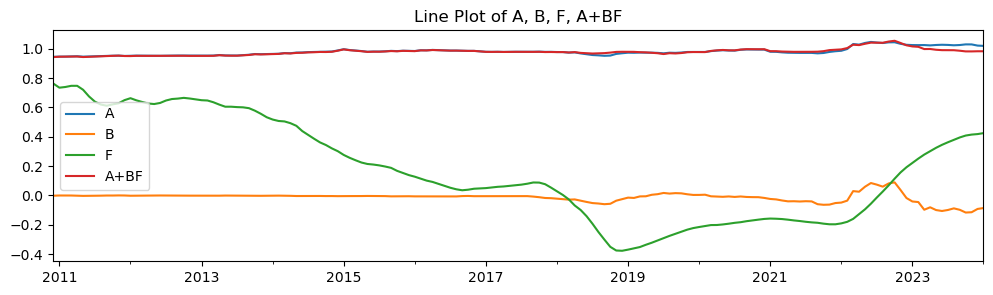

In [121]:
plt.figure(figsize=(15, 10)) 
df_coefs[['A', 'B', 'F', 'A+BF']].plot(kind='line')
plt.title('Line Plot of A, B, F, A+BF')
plt.legend()
plt.show()

The figure above shows the value of F for a 10-year rolling window.

<Axes: xlabel='index'>

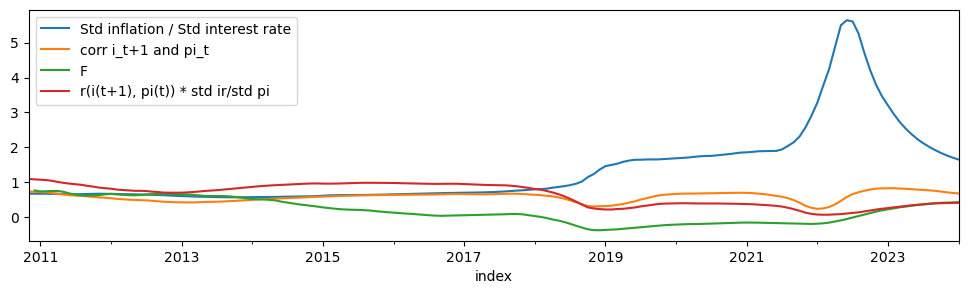

In [187]:
sub = df[['pi_Y_resid', 'ir']].dropna().copy()
sub = sub.join(sub.shift(-1).add_suffix('_lead1')).dropna()

window_size = 12 * 10
rolling_stats = []

for start in range(len(sub) - window_size + 1):
    end = start + window_size
    window = sub.iloc[start:end]
    corr_ir_lead1_pi_Y_resid = window['pi_Y_resid'].corr(window['ir_lead1'])
    std_pi_Y_resid = window['pi_Y_resid'].std()
    std_ir = window['ir'].std()
    ratio_std = std_pi_Y_resid / std_ir
    F_pred = corr_ir_lead1_pi_Y_resid / ratio_std
  
    rolling_stats.append({
        'index': sub.index[end-1],
        'corr i_t+1 and pi_t': corr_ir_lead1_pi_Y_resid,
        'Std inflation': std_pi_Y_resid,
        'Std interest rate': std_ir,
        'Std inflation / Std interest rate': ratio_std,
        'r(i(t+1), pi(t)) * std ir/std pi' : F_pred
    })

# Create DataFrame using the index
rolling_stats_df = pd.DataFrame(rolling_stats).set_index('index')

rolling_stats_df['F'] = df_coefs['F']
rolling_stats_df[['Std inflation / Std interest rate', 'corr i_t+1 and pi_t', 'F', 'r(i(t+1), pi(t)) * std ir/std pi']].plot()


When we see the correlation between interest rates in period t+1 and inflation in period t increase, we observe F decrease when the correlation between interest rates in period t+1 and inflation period t decrease. This is obvious because F reflects the responsiveness of the policy rate to inflation so is by definition the correlation. In our sample, F never exceeds one, even when the standard deviation ratio exceeds 1. F decreases in 2018 as the standard deviation ratio increases and the correlation decreases.

# References

Andrade, P., Breckenfelder, J., De Fiore, F., Karadi, P. and Tristani, O., 2016. The ECB's asset purchase programme: an early assessment.

Balke, N.S. and Emery, K.M., 1994. Understanding the price puzzle. Federal Reserve Bank of Dallas Economic Review, Fourth Quarter, pp.15-26.

Bureau of Labor Statistics (2022). What is seasonal adjustment? : U.S. Bureau of Labor Statistics. [online] Bls.gov. Available at: https://www.bls.gov/cps/seasfaq.htm [Accessed 31 Mar. 2024].

CEPR. (2024). Monetary policy responses to the post-pandemic inflation: Challenges and lessons for the future. [online] Available at: https://cepr.org/voxeu/columns/monetary-policy-responses-post-pandemic-inflation-challenges-and-lessons-future [Accessed 1 Apr. 2024].

Chatelain, J.B. and Ralf, K., 2018. Publish and Perish: Creative Destruction and Macroeconomic Theory.

EUROSTAT (2024) Harmonised index of consumer prices (HICP) (prc_hicp), Harmonised index of consumer prices (HICP) (PRC_HICP). Available at: https://ec.europa.eu/eurostat/cache/metadata/en/prc_hicp_esms.htm (Accessed: 30 March 2024). 

Hodrick, R.J. and Prescott, E.C. (1997). Postwar U.S. Business Cycles: An Empirical Investigation. Journal of Money, Credit and Banking, 29(1), p.1. doi:https://doi.org/10.2307/2953682.

OECD (2019). Trend Estimation Method. [online] Oecd-ilibrary.org. Available at: https://www.oecd-ilibrary.org/sites/361fabc3-en/index.html?itemId=/content/component/361fabc3-en [Accessed 31 Mar. 2024].

Romer, P. (2016) The trouble with Macroeconomics, The Trouble with Macroeconomics. Available at: https://paulromer.net/trouble-with-macroeconomics-update/WP-Trouble.pdf (Accessed: 14 April 2024). 

Rose, A.K., 1988. Is the real interest rate stable?. The Journal of Finance, 43(5), pp.1095-1112.

Stock, J.H. and Watson, M.W., 2020. Introduction to econometrics. Pearson.

World Bank (2018) What triggered the oil price plunge of 2014-2016 and why it failed to deliver an economic impetus in eight charts, World Bank Blogs. Available at: https://blogs.worldbank.org/en/developmenttalk/what-triggered-oil-price-plunge-2014-2016-and-why-it-failed-deliver-economic-impetus-eight-charts#:~:text=The%20initial%20drop%20in%20oil,mid%2D2015%20to%20early%202016. (Accessed: 15 April 2024). 

‌